In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import datetime as dt
import pandas as pd
import geopandas as gpd

import matplotlib.ticker as mticker
from netCDF4 import Dataset
from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim, ALL_TIMES, extract_times, g_times,
                 interpline, CoordPair, xy_to_ll, ll_to_xy)
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import geopy
import geopy.distance as geopd

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# path_out = '/home/users/baracoma/notebooks/wrf_expts/2022-01-26_intensity/'
wrf_path_base = '/gws/nopw/j04/klingaman/baracoma/WRF/out/runs'
path_out = '/home/users/baracoma/notebooks/wrf_expts/paper2'

crs = ccrs.PlateCarree()

lat_min = 13
lat_max = 19
lon_min = 118
lon_max = 125

lat_min_5deg = lat_min-5
lat_max_5deg = lat_max+5
lon_min_5deg = lon_min-5
lon_max_5deg = lon_max+5

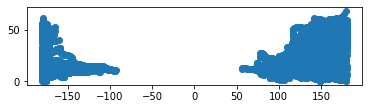

In [3]:
# ibtracs_path = '/home/users/baracoma/data/gis/ibtracs/v04/IBTrACS.WP.list.v04r00.line_post_1978.shp'
ibtracs_path = '/home/users/baracoma/data/gis/ibtracs/v04/IBTrACS.WP.list.v04r00.point_post_1978.shp'
ibtracs_path_line = '/home/users/baracoma/data/gis/ibtracs/v04/IBTrACS.WP.list.v04r00.line_post_1978.shp'
ibtracs = gpd.read_file(ibtracs_path)
ibtracs_line = gpd.read_file(ibtracs_path_line)
ibtracs.plot()
plt.show()

In [55]:
def get_track(nc_path_in):
    ds = xr.open_dataset(nc_path_in)
    print(nc_path_in)

    mslp_lon = []
    mslp_lat = []
    mslp_min = []
    mslp_date = []
    if 'bebinca' in nc_path_in:
        trackstart = 8        
    else:
        trackstart = 8
        
    if 'nesat' in nc_path_in:
        window = 1
    else:
        window = 1
#     window = 1    

    for i in range(ds.XTIME.shape[0]):
        datetime_str = str(ds.XTIME[i].values).split('.')[0]
        date_str = datetime_str.split('T')[0]
        time_str = datetime_str.split('T')[1]
        curr_dt = dt.datetime(int(date_str.split('-')[0]),int(date_str.split('-')[1]),int(date_str.split('-')[2]), int(time_str.split(':')[0]))
#         print(i)
        if i<trackstart:
            # adjust for bebinca since there is another TC
            if 'bebinca' in nc_path_in:

                mslp = get_mslp(ds, i)
                # mask here
                lat_conds = (mslp.XLAT < 15) 
                lon_conds = (mslp.XLONG > 126)
#                 lon_conds = (mslp.XLONG < (mslp_lon[i-1]+window)) & (mslp.XLONG > (mslp_lon[i-1]-window))
                mslp_ma = mslp.where((lat_conds&lon_conds), drop=True)                
                track = mslp_ma.where(mslp_ma==mslp_ma.min(), drop=True).squeeze()
                mslp_min.append(float(mslp.min()))
                mslp_lon.append(float(track.XLONG.values))
                mslp_lat.append(float(track.XLAT.values))
                # print(str(float(track.XLONG.values)) + ' ' + str(float(track.XLAT.values)))
            else:
                mslp = get_mslp(ds, i)
                track = mslp.where(mslp==mslp.min(), drop=True).squeeze()
                mslp_min.append(float(mslp.min()))
                mslp_lon.append(float(track.XLONG.values))
                mslp_lat.append(float(track.XLAT.values))
        else:
            mslp = get_mslp(ds, i)
            lat_conds = (mslp.XLAT < (mslp_lat[i-1]+window)) & (mslp.XLAT > (mslp_lat[i-1]-window))
            lon_conds = (mslp.XLONG < (mslp_lon[i-1]+window)) & (mslp.XLONG > (mslp_lon[i-1]-window))
            mslp_ma = mslp.where((lat_conds&lon_conds), drop=True)
            mslp_min_loc = mslp_ma.where(mslp_ma==mslp_ma.min(), drop=True).squeeze()
            if ('nesat_enha' in nc_path_in) and i==34:
                try:
                    mslp_min.append(float(mslp_min_loc[0]))
                except:
                    mslp_min.append(float(mslp_min_loc))
                mslp_lon.append(121)
                mslp_lat.append(16.25)
            elif 'bebinca' in nc_path_in:
#                 print('yes')
                mslp = get_mslp(ds, i)
                # mask here
                lat_conds = (mslp.XLAT < 16) 
#                 lon_conds = (mslp.XLONG < (mslp_lon[i-1]+window)) & (mslp.XLONG > (mslp_lon[i-1]-window))
                mslp_ma = mslp.where(lat_conds, drop=True)                
                track = mslp_ma.where(mslp_ma==mslp_ma.min(), drop=True).squeeze()
                mslp_min.append(float(mslp.min()))
                mslp_lon.append(float(track.XLONG.values))
                mslp_lat.append(float(track.XLAT.values))                
            else:
                try:
                    mslp_min.append(float(mslp_min_loc[0]))
                    mslp_lon.append(float(mslp_min_loc[0].XLONG))
                    mslp_lat.append(float(mslp_min_loc[0].XLAT))
                except:
                    mslp_min.append(float(mslp_min_loc))
                    mslp_lon.append(float(mslp_min_loc.XLONG))
                    mslp_lat.append(float(mslp_min_loc.XLAT))
        mslp_date.append(curr_dt)
    ds.close()
    if ('koppu_redu' in nc_path_in) or ('nari_enha' in nc_path_in) or ('nari_redu' in nc_path_in):
        return [mslp_lon[:-1], mslp_lat[:-1], mslp_min[:-1], mslp_date[:-1]]
    else:
        return [mslp_lon, mslp_lat, mslp_min, mslp_date]

def get_mslp(ds, i):
    """Gets ds from slice i and then calculates MSLP"""
    stemps = ds.T2[i]+6.5*ds.HGT[i]/1000.
    mslp = ds.PSFC[i]*np.exp(9.81/(287.0*stemps)*ds.HGT[i])*0.01 +(6.7 * ds.HGT[i] / 1000.)
    return mslp

In [54]:
def get_rain(nc_path_in):
    ds = xr.open_dataset(nc_path_in)
    print(nc_path_in)

    lm = ds.XLAND[0]
    lm = lm.where(lm!=2)
    
    lat_min_rain = 13.5
    lat_max_rain = 18.65
    lon_min_rain = 119.75
    lon_max_rain = 122.5

    q_conds = (ds.XLONG.values>=lon_min_rain) & (ds.XLONG.values<=lon_max_rain) & (ds.XLAT.values<=lat_max_rain) & (ds.XLAT.values>=lat_min_rain)
    q_up_lim = np.where(q_conds == True)[1][0]
    q_down_lim = np.where(q_conds == True)[1][-1]
    q_left_lim = np.where(q_conds == True)[2][0]
    q_right_lim = np.where(q_conds == True)[2][-1]
    
    rr_all = []

    for i in range(0, ds.XTIME.shape[0]-1):
        # YOU ARE CALCULATING FOR THE ACCUMULATED RAIN! CHANGE THIS TO INSTANTANEOUS!!!!!!!
        rr = np.nanmean((lm*((ds.RAINNC[i+1]+ds.RAINC[i+1])-(ds.RAINNC[i]+ds.RAINC[i]))).values[q_up_lim:q_down_lim, q_left_lim:q_right_lim])
        rr_all.append(rr/3.)

    if ('koppu_redu' in nc_path_in) or ('nari_enha' in nc_path_in) or ('nari_redu' in nc_path_in):
        return rr_all[:-1]       
    else:
        return rr_all

In [23]:
def get_rain_mnt_2(nc_path_in):
    ds = xr.open_dataset(nc_path_in)
    print(nc_path_in)

# get mountain regions for precipitation 

    xlong = ds['XLONG'][0]
    xlat = ds['XLAT'][0]

    # lat_min = 13
    # lat_max = 19
    # lon_min = 118
    # lon_max = 125

    q1_lat_max_mnt = 18.5
    q1_lat_min_mnt = 16
    q1_lon_max_mnt = 121.35
    q1_lon_min_mnt = 120.5

    # mountain mnt
    q1_conds_mnt = (xlong >= q1_lon_min_mnt) & (xlong <= q1_lon_max_mnt) & (xlat >= q1_lat_min_mnt) & (xlat <= q1_lat_max_mnt)
    q1_conds_lon_mnt = (xlong >= q1_lat_min_mnt) & (xlong <= q1_lon_max_mnt)
    q1_conds_lat_mnt = (xlat >= q1_lat_min_mnt) & (xlat <= q1_lat_max_mnt)

    q1_up_lim_mnt = np.where(q1_conds_mnt == True)[0][0]
    q1_down_lim_mnt = np.where(q1_conds_mnt == True)[0][-1]
    q1_left_lim_mnt = np.where(q1_conds_mnt == True)[1][0]
    q1_right_lim_mnt = np.where(q1_conds_mnt == True)[1][-1]

    rr_all = []    
    for i in range(0, ds.XTIME.shape[0]-1):
        rr = ((ds['RAINNC'][i+1]+ds['RAINC'][i+1])-(ds['RAINNC'][i]+ds['RAINC'][i]))/3.    

        rr_1_crop = rr[q1_up_lim_mnt:q1_down_lim_mnt, q1_left_lim_mnt:q1_right_lim_mnt]
        # rr_mnt = np.concatenate([rr_1_crop.values.flatten(), rr_2_crop.values.flatten(), rr_3_crop.values.flatten()])
        rr_mean = np.mean(rr_1_crop)    
        rr_all.append(rr_mean)

    if ('koppu_redu' in nc_path_in) or ('nari_enha' in nc_path_in) or ('nari_redu' in nc_path_in):
        return rr_all[:-1]       
    else:
        return rr_all

In [56]:
lf_list = pd.read_csv(os.path.join('/home/users/baracoma/notebooks/wrf_expts/2021-05-11', 'lf_list_processing.csv'))
lf_list['DateStr'] = lf_list['LF Year'].apply(str) + lf_list['LF Month'].apply(str).str.zfill(2) + lf_list['LF Date'].apply(str).str.zfill(2) + lf_list['LF Hour'].apply(str).str.zfill(2)
lf_list['DateStr'] = pd.to_datetime(lf_list['DateStr'], format="%Y%m%d%H")
lf_list = lf_list.set_index('NAME')
tc_incl = ['KOPPU', 'NESAT', 'MEGI', 'IMBUDO', 'CIMARON', 'BEBINCA', 'NARI', 'PRAPIROON']
lf_list = lf_list[lf_list.index.isin(tc_incl)]

lf_list['orig_i'] = ""
lf_list['redu_i'] = ""
lf_list['enha_i'] = ""
lf_list['dt'] = ""

lf_list['lon_o'] = ""
lf_list['lat_o'] = ""
lf_list['lon_r'] = ""
lf_list['lat_r'] = ""
lf_list['lon_e'] = ""
lf_list['lat_e'] = ""

lf_list['rain_o'] = ""
lf_list['rain_e'] = ""
lf_list['rain_r'] = ""

lf_list['rain_mnt_o'] = ""
lf_list['rain_mnt_e'] = ""
lf_list['rain_mnt_r'] = ""

for tcname in lf_list.index:
# for tcname in ['BEBINCA']:    
    print(tcname)
    tc_path_orig = os.path.join(wrf_path_base,tcname.lower()+'_'+'orig')
    tc_path_enha = os.path.join(wrf_path_base,tcname.lower()+'_'+'enha')
    tc_path_redu = os.path.join(wrf_path_base,tcname.lower()+'_'+'redu')

    tc_list = os.listdir(tc_path_orig)
    for wrf_ncs in tc_list:
        if wrf_ncs[0:10]=='wrfout_d02':
            wrf_nc = wrf_ncs

    tc_nc_path_orig = os.path.join(tc_path_orig, wrf_nc)
    tc_nc_path_enha = os.path.join(tc_path_enha, wrf_nc)
    tc_nc_path_redu = os.path.join(tc_path_redu, wrf_nc)

    orig_ds =  xr.open_dataset(tc_nc_path_orig)
    redu_ds =  xr.open_dataset(tc_nc_path_enha)
    enha_ds =  xr.open_dataset(tc_nc_path_redu)

    lf_pt_o = lf_list['o_ts'][tcname]
    lf_pt_e = lf_list['e_ts'][tcname]
    lf_pt_r = lf_list['r_ts'][tcname]

    lon_o, lat_o, mslp_min_o, mslp_date_o = get_track(tc_nc_path_orig)
    lon_e, lat_e, mslp_min_e, mslp_date_e = get_track(tc_nc_path_enha)
    lon_r, lat_r, mslp_min_r, mslp_date_r = get_track(tc_nc_path_redu)
    
    lf_list['orig_i'][tcname] = mslp_min_o
    lf_list['redu_i'][tcname] = mslp_min_r
    lf_list['enha_i'][tcname] = mslp_min_e
    lf_list['dt'][tcname] = mslp_min_o
    
    lf_list['lon_o'][tcname] = lon_o
    lf_list['lat_o'][tcname] = lat_o
    lf_list['lon_r'][tcname] = lon_r
    lf_list['lat_r'][tcname] = lat_r
    lf_list['lon_e'][tcname] = lon_e
    lf_list['lat_e'][tcname] = lat_e

    # Luzon rain
    rain_o = get_rain(tc_nc_path_orig)
    rain_e = get_rain(tc_nc_path_enha)
    rain_r = get_rain(tc_nc_path_redu)
    lf_list['rain_o'][tcname] = rain_o
    lf_list['rain_e'][tcname] = rain_e
    lf_list['rain_r'][tcname] = rain_r

    # Mountain rain
    rain_mnt_o = get_rain_mnt_2(tc_nc_path_orig)
    rain_mnt_e = get_rain_mnt_2(tc_nc_path_enha)
    rain_mnt_r = get_rain_mnt_2(tc_nc_path_redu)
    lf_list['rain_mnt_o'][tcname] = rain_mnt_o
    lf_list['rain_mnt_e'][tcname] = rain_mnt_e
    lf_list['rain_mnt_r'][tcname] = rain_mnt_r
    
# manually adjust selected tracks
tc_mod = 'MEGI'
lf_list.at[tc_mod, 'lon_e'][31] = 121.25
lf_list.at[tc_mod, 'lat_e'][31] = 16.25

lf_list.at[tc_mod, 'lon_e'][32] = 120.35
lf_list.at[tc_mod, 'lat_e'][32] = 15.5

lf_list.at[tc_mod, 'lon_e'][33] = 120.10
lf_list.at[tc_mod, 'lat_e'][33] = 15.25
tc_mod = 'IMBUDO'
lf_list.at[tc_mod, 'lon_e'][34] = 121.25
lf_list.at[tc_mod, 'lat_e'][34] = 17.6
lf_list.to_pickle(os.path.join(path_out,'lf_list_intensitywithmntrain.pkl'))

MEGI
/gws/nopw/j04/klingaman/baracoma/WRF/out/runs/megi_orig/wrfout_d02_2010-10-14_06:00:00
/gws/nopw/j04/klingaman/baracoma/WRF/out/runs/megi_enha/wrfout_d02_2010-10-14_06:00:00
/gws/nopw/j04/klingaman/baracoma/WRF/out/runs/megi_redu/wrfout_d02_2010-10-14_06:00:00
/gws/nopw/j04/klingaman/baracoma/WRF/out/runs/megi_orig/wrfout_d02_2010-10-14_06:00:00
/gws/nopw/j04/klingaman/baracoma/WRF/out/runs/megi_enha/wrfout_d02_2010-10-14_06:00:00
/gws/nopw/j04/klingaman/baracoma/WRF/out/runs/megi_redu/wrfout_d02_2010-10-14_06:00:00
/gws/nopw/j04/klingaman/baracoma/WRF/out/runs/megi_orig/wrfout_d02_2010-10-14_06:00:00
/gws/nopw/j04/klingaman/baracoma/WRF/out/runs/megi_enha/wrfout_d02_2010-10-14_06:00:00
/gws/nopw/j04/klingaman/baracoma/WRF/out/runs/megi_redu/wrfout_d02_2010-10-14_06:00:00
IMBUDO
/gws/nopw/j04/klingaman/baracoma/WRF/out/runs/imbudo_orig/wrfout_d02_2003-07-18_03:00:00
/gws/nopw/j04/klingaman/baracoma/WRF/out/runs/imbudo_enha/wrfout_d02_2003-07-18_03:00:00
/gws/nopw/j04/klingaman/bar

In [5]:
lf_list = pd.read_pickle(os.path.join(path_out,'lf_list_intensitywithmntrain.pkl'))

In [6]:
lf_list = lf_list.reindex(['KOPPU', 'NESAT', 'MEGI', 'IMBUDO', 'CIMARON', 'BEBINCA', 'NARI', 'PRAPIROON'])

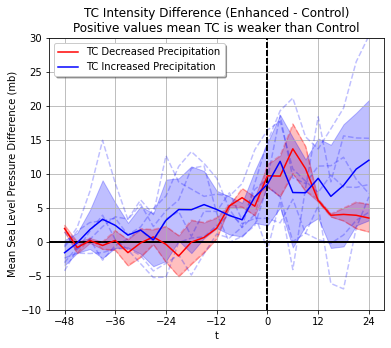

In [39]:
enha_i_shift_red = []
enha_i_shift_inc = []
enha_i_shift_all = []

orig_i_all = []
lim_do = -48
lim_up = 24
for tcname in lf_list.index:
    # shift the coordinates to match LF timestep
    o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']))
    e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']))
    r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts']))

    shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
    shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']

    orig_i = np.array(lf_list.loc[tcname]['orig_i'])
    enha_i_shift = np.roll(np.array(lf_list.loc[tcname]['enha_i']), shift_e)
    redu_i_shift = np.roll(np.array(lf_list.loc[tcname]['redu_i']), shift_r)

#     plt.plot(np.array(o_t)[8:], (orig_i - enha_i_shift)[8:], 'blue', label='Control - Enhanced', alpha=0.75)
#     plt.plot(o_t[8:], (orig_i - redu_i_shift)[8:], 'red', label='Control - Reduced', alpha=0.75)
    if tcname in ["IMBUDO", "PRAPIROON"]:
        plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', linestyle='--', alpha=0.25)
        enha_i_shift_red.append((enha_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)])
    else:
        plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', linestyle='--', alpha=0.25)
        enha_i_shift_inc.append((enha_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)])
    enha_i_shift_all.append((enha_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)])
        #     plt.plot(o_t[np.abs(o_t)<=24], (redu_i_shift - orig_i)[np.abs(o_t)<=24], 'red', label='Reduced - Control', alpha=0.75)    

#     plt.plot(o_t[np.abs(o_t)<=24], (orig_i - enha_i_shift)[np.abs(o_t)<=24], 'blue', label='Control - Enhanced', alpha=0.75)
#     plt.plot(o_t[np.abs(o_t)<=24], (orig_i - redu_i_shift)[np.abs(o_t)<=24], 'red', label='Control - Reduced', alpha=0.75)    
    
    
    plt.ylabel('Mean Sea Level Pressure Difference (mb)')
    plt.xlabel('t')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mticker.MultipleLocator(12))
#     legend = ax.legend(loc='upper left', shadow=True)

    fig = plt.gcf()
    fig.set_size_inches(6,5)
    plt.axvline(x=0, color='k', linestyle='--', alpha=1)
    plt.axhline(y=0, color='k', linestyle='-', alpha=.5)
    plt.ylim(-10, 30)
    plt.title('TC Intensity Difference (Enhanced - Control)\nPositive values mean TC is weaker than Control')
    plt.grid()
#     plt.savefig(os.path.join(path_out,tcname.lower()+'_intdiff.png'), bbox_inches='tight', facecolor='white')
enha_i_shift_red_mean = np.array(enha_i_shift_red).mean(axis=0)
enha_i_shift_inc_mean = np.array(enha_i_shift_inc).mean(axis=0)
enha_i_shift_red_std = np.array(enha_i_shift_red).std(axis=0)
enha_i_shift_inc_std = np.array(enha_i_shift_inc).std(axis=0)

enha_i_shift_all_mean = np.array(enha_i_shift_all).mean(axis=0)
enha_i_shift_all_std = np.array(enha_i_shift_all).std(axis=0)

plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], enha_i_shift_red_mean, 'red', alpha=1, label='TC Decreased Precipitation')
plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], enha_i_shift_inc_mean, 'blue', alpha=1, label='TC Increased Precipitation')

plt.fill_between(o_t[(o_t<=lim_up) & (o_t>=lim_do)], enha_i_shift_red_mean-enha_i_shift_red_std, enha_i_shift_red_mean+enha_i_shift_red_std, facecolor='red', color='red', alpha=0.25)
plt.fill_between(o_t[(o_t<=lim_up) & (o_t>=lim_do)], enha_i_shift_inc_mean-enha_i_shift_inc_std, enha_i_shift_inc_mean+enha_i_shift_inc_std, facecolor='blue', color='blue', alpha=0.25)
legend = ax.legend(loc='upper left', shadow=True)
plt.grid()
# plt.savefig(os.path.join(path_out,'enha_intdiff.png'), bbox_inches='tight', facecolor='white')
plt.show()

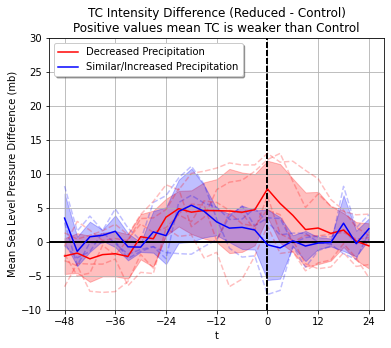

In [40]:
# tcname = 'IMBUDO'
# lf_list.loc[tcname]
redu_i_shift_red = []
redu_i_shift_inc = []
redu_i_shift_all = []
orig_i_all = []

for tcname in lf_list.index:
    # shift the coordinates to match LF timestep
    o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']))
    e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']))
    r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts']))

    shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
    shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']

    orig_i = np.array(lf_list.loc[tcname]['orig_i'])
    enha_i_shift = np.roll(np.array(lf_list.loc[tcname]['enha_i']), shift_e)
    redu_i_shift = np.roll(np.array(lf_list.loc[tcname]['redu_i']), shift_r)

#     plt.plot(np.array(o_t)[8:], (orig_i - enha_i_shift)[8:], 'blue', label='Control - Enhanced', alpha=0.75)
#     plt.plot(o_t[8:], (orig_i - redu_i_shift)[8:], 'red', label='Control - Reduced', alpha=0.75)
    if tcname in ["IMBUDO", "MEGI", "KOPPU"]:
        plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', linestyle='--', alpha=0.25)
        redu_i_shift_inc.append((redu_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)])
    else:
        plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', linestyle='--', alpha=0.25)
        redu_i_shift_red.append((redu_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)])
        
        #     plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', label='Reduced - Control', alpha=0.75)    
    redu_i_shift_all.append((redu_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)])
#     plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (orig_i - enha_i_shift)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', label='Control - Enhanced', alpha=0.75)
#     plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (orig_i - redu_i_shift)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', label='Control - Reduced', alpha=0.75)    
    
    
    plt.ylabel('Mean Sea Level Pressure Difference (mb)')
    plt.xlabel('t')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mticker.MultipleLocator(12))
#     legend = ax.legend(loc='upper left', shadow=True)

    fig = plt.gcf()
    fig.set_size_inches(6,5)
    plt.axvline(x=0, color='k', linestyle='--', alpha=1)
    plt.axhline(y=0, color='k', linestyle='-', alpha=.5)
    plt.ylim(-10, 30)
    plt.title('TC Intensity Difference (Reduced - Control)\nPositive values mean TC is weaker than Control')
    plt.grid()
#     plt.savefig(os.path.join(path_out,tcname.lower()+'_intdiff.png'), bbox_inches='tight', facecolor='white')
redu_i_shift_red_mean = np.array(redu_i_shift_red).mean(axis=0)
redu_i_shift_inc_mean = np.array(redu_i_shift_inc).mean(axis=0)
redu_i_shift_red_std = np.array(redu_i_shift_red).std(axis=0)
redu_i_shift_inc_std = np.array(redu_i_shift_inc).std(axis=0)

redu_i_shift_all_mean = np.array(redu_i_shift_all).mean(axis=0)
redu_i_shift_all_std = np.array(redu_i_shift_all).std(axis=0)

plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], redu_i_shift_red_mean, 'red', alpha=1, label='Decreased Precipitation')
plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], redu_i_shift_inc_mean, 'blue', alpha=1, label='Similar/Increased Precipitation')

plt.fill_between(o_t[(o_t<=lim_up) & (o_t>=lim_do)], redu_i_shift_red_mean-redu_i_shift_red_std, redu_i_shift_red_mean+redu_i_shift_red_std, facecolor='red', color='red', alpha=0.25)
plt.fill_between(o_t[(o_t<=lim_up) & (o_t>=lim_do)], redu_i_shift_inc_mean-redu_i_shift_inc_std, redu_i_shift_inc_mean+redu_i_shift_inc_std, facecolor='blue', color='blue', alpha=0.25)
legend = ax.legend(loc='upper left', shadow=True)
plt.grid()
# plt.savefig(os.path.join(path_out,'redu_intdiff.png'), bbox_inches='tight', facecolor='white')
plt.show()

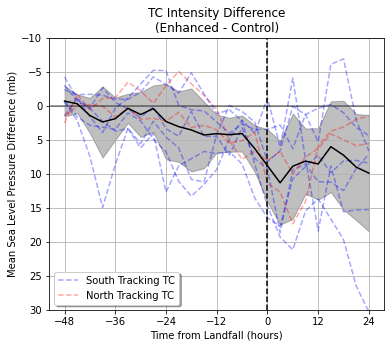

In [37]:
lim_do = -48
lim_up = 24
label1 = False
label2 = False
for tcname in lf_list.index:
    o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']))
    e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']))
    r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts'])) 
    shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
    shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']    
    orig_i = np.array(lf_list.loc[tcname]['orig_i'])
    enha_i_shift = np.roll(np.array(lf_list.loc[tcname]['enha_i']), shift_e)
    redu_i_shift = np.roll(np.array(lf_list.loc[tcname]['redu_i']), shift_r)
    if tcname in ["IMBUDO", "PRAPIROON"]: 
        if not label1:    
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', linestyle='--', alpha=0.35, label='North Tracking TC')
            label1 = True
        else:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', linestyle='--', alpha=0.35)    
    else:
        if not label2: 
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', linestyle='--', alpha=0.35, label='South Tracking TC')
            label2 = True
        else:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', linestyle='--', alpha=0.35)
    orig_i_24 = np.mean(orig_i[(o_t>=0) & (o_t<=24)])-1000
    redu_i_24 = np.mean(redu_i_shift[(r_t>=0) & (r_t<=24)])-1000 
    enha_i_24 = np.mean(enha_i_shift[(e_t>=0) & (e_t<=24)])-1000


plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], enha_i_shift_all_mean, 'black', alpha=1)
plt.fill_between(o_t[(o_t<=lim_up) & (o_t>=lim_do)], enha_i_shift_all_mean-enha_i_shift_all_std, enha_i_shift_all_mean+enha_i_shift_all_std, facecolor='black', color='black', alpha=0.25)
plt.ylabel('Mean Sea Level Pressure Difference (mb)')
plt.xlabel('Time from Landfall (hours)')

ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MultipleLocator(12))
# ax.invert_yaxis()
legend = ax.legend(loc='lower left', shadow=True)

fig = plt.gcf()
fig.set_size_inches(6,5)
plt.axvline(x=0, color='k', linestyle='--', alpha=1)
plt.axhline(y=0, color='k', linestyle='-', alpha=.5)
# plt.ylim(-10, 30)
plt.ylim(30, -10)
plt.title('TC Intensity Difference\n(Enhanced - Control)')
plt.grid()
# plt.savefig(os.path.join(path_out,'enha_intdiff_all_colored.png'), bbox_inches='tight', facecolor='white')
plt.show()

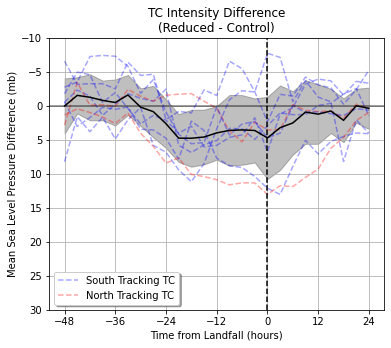

In [41]:
lim_do = -48
lim_up = 24
label1 = False
label2 = False
for tcname in lf_list.index:
    o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']))
    e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']))
    r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts'])) 
    shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
    shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']    
    orig_i = np.array(lf_list.loc[tcname]['orig_i'])
    enha_i_shift = np.roll(np.array(lf_list.loc[tcname]['enha_i']), shift_e)
    redu_i_shift = np.roll(np.array(lf_list.loc[tcname]['redu_i']), shift_r)
    
    if tcname in ["IMBUDO", "PRAPIROON"]: 
        if not label1:    
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', linestyle='--', alpha=0.35, label='North Tracking TC')
            label1 = True
        else:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', linestyle='--', alpha=0.35)
    else:
        if not label2:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', linestyle='--', alpha=0.35, label='South Tracking TC')
            label2 = True
        else:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_i_shift - orig_i)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', linestyle='--', alpha=0.35)    
plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], redu_i_shift_all_mean, 'black', alpha=1)
plt.fill_between(o_t[(o_t<=lim_up) & (o_t>=lim_do)], redu_i_shift_all_mean-redu_i_shift_all_std, redu_i_shift_all_mean+redu_i_shift_all_std, facecolor='black', color='black', alpha=0.25)
plt.ylabel('Mean Sea Level Pressure Difference (mb)')
plt.xlabel('Time from Landfall (hours)')

ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MultipleLocator(12))
legend = ax.legend(loc='lower left', shadow=True)

fig = plt.gcf()
fig.set_size_inches(6,5)
plt.axvline(x=0, color='k', linestyle='--', alpha=1)
plt.axhline(y=0, color='k', linestyle='-', alpha=.5)
plt.ylim(30, -10)
plt.title('TC Intensity Difference\n(Reduced - Control)')
plt.grid()
# plt.savefig(os.path.join(path_out,'redu_intdiff_all_colored.png'), bbox_inches='tight', facecolor='white')
plt.show()

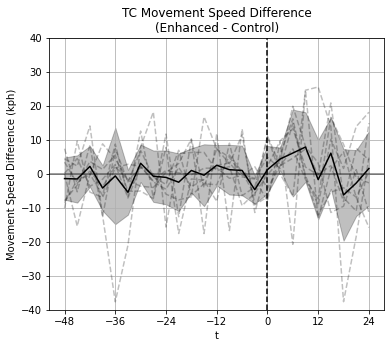

In [42]:
# Calculate for long t=0 to t=24
enha_i_spd_red = []
enha_i_spd_inc = []
enha_i_spd_all = []
redu_i_spd_all = []

lim_do = -48
lim_up = 24

for tcname in lf_list.index:
# for tcname in ['BEBINCA']:
    # shift the coordinates to match LF timestep
    o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']))
    e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']))
    r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts']))

    shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
    shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']

    orig_lat = np.array(lf_list.loc[tcname]['lat_o'])
    orig_lon = np.array(lf_list.loc[tcname]['lon_o'])
    enha_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_e']), shift_e)
    enha_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_e']), shift_e)
    redu_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_r']), shift_r)
    redu_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_r']), shift_r)
    

#     orig_lat_next = np.roll(orig_lat,1)
#     orig_lon_next = np.roll(orig_lon, 1)
    
#     redu_lat_next = np.roll(redu_lon_shift, 1)
#     redu_lon_next = np.roll(redu_lon_shift, 1)

#     enha_lat_next = np.roll(enha_lat_shift, 1)
#     enha_lon_next = np.roll(enha_lon_shift, 1)
    
    dist_o_all = []
    dist_e_all = []
    dist_r_all = []    
    
    for i in range(len(orig_lat)-1):
        pt_o = (orig_lat[i], orig_lon[i])
        pt_e = (enha_lat_shift[i], enha_lon_shift[i])
        pt_r = (redu_lat_shift[i], redu_lon_shift[i])
        
        pt_o_n = (orig_lat[i+1], orig_lon[i+1])
        pt_e_n = (enha_lat_shift[i+1], enha_lon_shift[i+1])
        pt_r_n = (redu_lat_shift[i+1], redu_lon_shift[i+1])           
        
        dist_o = geopd.distance(pt_o, pt_o_n).km
        dist_e = geopd.distance(pt_e, pt_e_n).km
        dist_r = geopd.distance(pt_r, pt_r_n).km
        dist_o_all.append(dist_o/3.)
        dist_e_all.append(dist_e/3.)
        dist_r_all.append(dist_r/3.)    
    dist_o_all = np.array(dist_o_all)
    dist_e_all = np.array(dist_e_all)
    dist_r_all = np.array(dist_r_all)
    
    o_t_n = o_t[1:]
    
    o_t_c = o_t_n[(o_t_n<=lim_up) & (o_t_n>=lim_do)]
    dist_o_c = dist_o_all[(o_t_n<=lim_up) & (o_t_n>=lim_do)]
    dist_e_c = dist_e_all[(o_t_n<=lim_up) & (o_t_n>=lim_do)]
    dist_r_c = dist_r_all[(o_t_n<=lim_up) & (o_t_n>=lim_do)]
    
    plt.plot(o_t_c, dist_e_c-dist_o_c, 'black', linestyle='--', alpha=0.25)
#     plt.show()
#     print(tcname)
    
    enha_i_spd_all.append(dist_e_c-dist_o_c)
    redu_i_spd_all.append(dist_r_c-dist_o_c)

# o_t_n = o_t[1:]
enha_i_spd_mean = np.array(enha_i_spd_all).mean(axis=0)
enha_i_spd_std = np.array(enha_i_spd_all).std(axis=0)

plt.plot(o_t_c, enha_i_spd_mean, 'black', alpha=1)
plt.fill_between(o_t_c, enha_i_spd_mean-enha_i_spd_std, enha_i_spd_mean+enha_i_spd_std, facecolor='black', color='black', alpha=0.25)
plt.ylabel('Movement Speed Difference (kph)')
plt.xlabel('t')
plt.ylim(-40, 40)

ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MultipleLocator(12))
fig = plt.gcf()
fig.set_size_inches(6,5)
plt.axvline(x=0, color='k', linestyle='--', alpha=1)
plt.axhline(y=0, color='k', linestyle='-', alpha=.5)
# plt.ylim(-10, 30)
plt.title('TC Movement Speed Difference\n(Enhanced - Control)')
plt.grid()
# plt.savefig(os.path.join(path_out,'enha_spddiff.png'), bbox_inches='tight', facecolor='white')
plt.show()

redu_i_spd_mean = np.array(redu_i_spd_all).mean(axis=0)
redu_i_spd_std = np.array(redu_i_spd_all).std(axis=0)

# plt.plot(o_t_c, redu_i_spd_mean, 'black', alpha=1)
# plt.fill_between(o_t_c, redu_i_spd_mean-redu_i_spd_std, redu_i_spd_mean+redu_i_spd_std, facecolor='black', color='black', alpha=0.25)
# plt.ylabel('Movement Speed Difference (kph)')
# plt.xlabel('t')
# plt.ylim(-40, 40)


# ax = plt.gca()
# ax.xaxis.set_major_locator(mticker.MultipleLocator(12))
# fig = plt.gcf()
# fig.set_size_inches(6,5)
# plt.axvline(x=0, color='k', linestyle='--', alpha=1)
# plt.axhline(y=0, color='k', linestyle='-', alpha=.5)
# # plt.ylim(-10, 30)
# plt.title('TC Movement Speed Difference (Reduced - Control)')
# plt.grid()
# plt.savefig(os.path.join(path_out,'enha_spddiff.png'), bbox_inches='tight', facecolor='white')

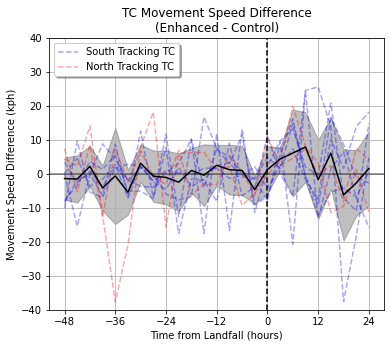

In [43]:
enha_i_spd_red = []
enha_i_spd_inc = []
enha_i_spd_all = []
redu_i_spd_all = []

lim_do = -48
lim_up = 24

label1 = False
label2 = False

for tcname in lf_list.index:
# for tcname in ['BEBINCA']:
    # shift the coordinates to match LF timestep
    o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']))
    e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']))
    r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts']))

    shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
    shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']

    orig_lat = np.array(lf_list.loc[tcname]['lat_o'])
    orig_lon = np.array(lf_list.loc[tcname]['lon_o'])
    enha_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_e']), shift_e)
    enha_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_e']), shift_e)
    redu_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_r']), shift_r)
    redu_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_r']), shift_r)
    

#     orig_lat_next = np.roll(orig_lat,1)
#     orig_lon_next = np.roll(orig_lon, 1)
    
#     redu_lat_next = np.roll(redu_lon_shift, 1)
#     redu_lon_next = np.roll(redu_lon_shift, 1)

#     enha_lat_next = np.roll(enha_lat_shift, 1)
#     enha_lon_next = np.roll(enha_lon_shift, 1)
    
    dist_o_all = []
    dist_e_all = []
    dist_r_all = []    
    
    for i in range(len(orig_lat)-1):
        pt_o = (orig_lat[i], orig_lon[i])
        pt_e = (enha_lat_shift[i], enha_lon_shift[i])
        pt_r = (redu_lat_shift[i], redu_lon_shift[i])
        
        pt_o_n = (orig_lat[i+1], orig_lon[i+1])
        pt_e_n = (enha_lat_shift[i+1], enha_lon_shift[i+1])
        pt_r_n = (redu_lat_shift[i+1], redu_lon_shift[i+1])           
        
        dist_o = geopd.distance(pt_o, pt_o_n).km
        dist_e = geopd.distance(pt_e, pt_e_n).km
        dist_r = geopd.distance(pt_r, pt_r_n).km
        dist_o_all.append(dist_o/3.)
        dist_e_all.append(dist_e/3.)
        dist_r_all.append(dist_r/3.)    
    dist_o_all = np.array(dist_o_all)
    dist_e_all = np.array(dist_e_all)
    dist_r_all = np.array(dist_r_all)
    
    o_t_n = o_t[1:]
    
    o_t_c = o_t_n[(o_t_n<=lim_up) & (o_t_n>=lim_do)]
    dist_o_c = dist_o_all[(o_t_n<=lim_up) & (o_t_n>=lim_do)]
    dist_e_c = dist_e_all[(o_t_n<=lim_up) & (o_t_n>=lim_do)]
    dist_r_c = dist_r_all[(o_t_n<=lim_up) & (o_t_n>=lim_do)]
    
    if tcname in ["IMBUDO", "PRAPIROON"]: 
        if not label1:
            plt.plot(o_t_c, dist_e_c-dist_o_c, 'red', linestyle='--', alpha=0.35, label='North Tracking TC')
            label1 = True
        else:
            plt.plot(o_t_c, dist_e_c-dist_o_c, 'red', linestyle='--', alpha=0.35)            
    else:
        if not label2:
            plt.plot(o_t_c, dist_e_c-dist_o_c, 'blue', linestyle='--', alpha=0.35, label='South Tracking TC')
            label2 = True
        else:
            plt.plot(o_t_c, dist_e_c-dist_o_c, 'blue', linestyle='--', alpha=0.35)    
    
#     plt.plot(o_t_c, dist_e_c-dist_o_c, 'black', linestyle='--', alpha=0.25)
#     plt.show()
#     print(tcname)
    
    enha_i_spd_all.append(dist_e_c-dist_o_c)
    redu_i_spd_all.append(dist_r_c-dist_o_c)

# o_t_n = o_t[1:]
enha_i_spd_mean = np.array(enha_i_spd_all).mean(axis=0)
enha_i_spd_std = np.array(enha_i_spd_all).std(axis=0)

plt.plot(o_t_c, enha_i_spd_mean, 'black', alpha=1)
plt.fill_between(o_t_c, enha_i_spd_mean-enha_i_spd_std, enha_i_spd_mean+enha_i_spd_std, facecolor='black', color='black', alpha=0.25)
plt.ylabel('Movement Speed Difference (kph)')
plt.xlabel('Time from Landfall (hours)')
plt.ylim(-40, 40)

ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MultipleLocator(12))
fig = plt.gcf()
fig.set_size_inches(6,5)
plt.axvline(x=0, color='k', linestyle='--', alpha=1)
plt.axhline(y=0, color='k', linestyle='-', alpha=.5)
# plt.ylim(-10, 30)
plt.title('TC Movement Speed Difference\n(Enhanced - Control)')
plt.grid()
legend = ax.legend(loc='upper left', shadow=True)
# plt.savefig(os.path.join(path_out,'enha_spddiff_colored.png'), bbox_inches='tight', facecolor='white')
plt.show()

redu_i_spd_mean = np.array(redu_i_spd_all).mean(axis=0)
redu_i_spd_std = np.array(redu_i_spd_all).std(axis=0)


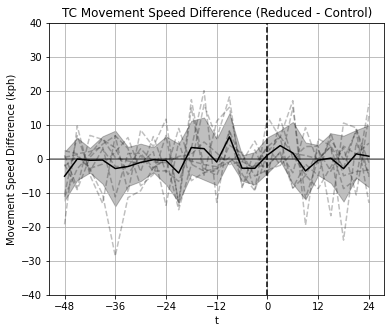

In [44]:
enha_i_spd_red = []
enha_i_spd_inc = []
enha_i_spd_all = []
redu_i_spd_all = []

lim_do = -48
lim_up = 24

for tcname in lf_list.index:
# for tcname in ['BEBINCA']:
    # shift the coordinates to match LF timestep
    o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']))
    e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']))
    r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts']))

    shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
    shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']

    orig_lat = np.array(lf_list.loc[tcname]['lat_o'])
    orig_lon = np.array(lf_list.loc[tcname]['lon_o'])
    enha_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_e']), shift_e)
    enha_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_e']), shift_e)
    redu_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_r']), shift_r)
    redu_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_r']), shift_r)
    

#     orig_lat_next = np.roll(orig_lat,1)
#     orig_lon_next = np.roll(orig_lon, 1)
    
#     redu_lat_next = np.roll(redu_lon_shift, 1)
#     redu_lon_next = np.roll(redu_lon_shift, 1)

#     enha_lat_next = np.roll(enha_lat_shift, 1)
#     enha_lon_next = np.roll(enha_lon_shift, 1)
    
    dist_o_all = []
    dist_e_all = []
    dist_r_all = []    
    
    for i in range(len(orig_lat)-1):
        pt_o = (orig_lat[i], orig_lon[i])
        pt_e = (enha_lat_shift[i], enha_lon_shift[i])
        pt_r = (redu_lat_shift[i], redu_lon_shift[i])
        
        pt_o_n = (orig_lat[i+1], orig_lon[i+1])
        pt_e_n = (enha_lat_shift[i+1], enha_lon_shift[i+1])
        pt_r_n = (redu_lat_shift[i+1], redu_lon_shift[i+1])           
        
        dist_o = geopd.distance(pt_o, pt_o_n).km
        dist_e = geopd.distance(pt_e, pt_e_n).km
        dist_r = geopd.distance(pt_r, pt_r_n).km
        dist_o_all.append(dist_o/3.)
        dist_e_all.append(dist_e/3.)
        dist_r_all.append(dist_r/3.)    
    dist_o_all = np.array(dist_o_all)
    dist_e_all = np.array(dist_e_all)
    dist_r_all = np.array(dist_r_all)
    
    o_t_n = o_t[1:]
    
    o_t_c = o_t_n[(o_t_n<=lim_up) & (o_t_n>=lim_do)]
    dist_o_c = dist_o_all[(o_t_n<=lim_up) & (o_t_n>=lim_do)]
    dist_e_c = dist_e_all[(o_t_n<=lim_up) & (o_t_n>=lim_do)]
    dist_r_c = dist_r_all[(o_t_n<=lim_up) & (o_t_n>=lim_do)]
    
    plt.plot(o_t_c, dist_r_c-dist_o_c, 'black', linestyle='--', alpha=0.25)
#     plt.show()
#     print(tcname)
    
    enha_i_spd_all.append(dist_e_c-dist_o_c)
    redu_i_spd_all.append(dist_r_c-dist_o_c)

# o_t_n = o_t[1:]
enha_i_spd_mean = np.array(enha_i_spd_all).mean(axis=0)
enha_i_spd_std = np.array(enha_i_spd_all).std(axis=0)

# plt.plot(o_t_c, enha_i_spd_mean, 'black', alpha=1)
# plt.fill_between(o_t_c, enha_i_spd_mean-enha_i_spd_std, enha_i_spd_mean+enha_i_spd_std, facecolor='black', color='black', alpha=0.25)
# plt.ylabel('Movement Speed Difference (kph)')
# plt.xlabel('t')
# plt.ylim(-40, 40)

# ax = plt.gca()
# ax.xaxis.set_major_locator(mticker.MultipleLocator(12))
# fig = plt.gcf()
# fig.set_size_inches(6,5)
# plt.axvline(x=0, color='k', linestyle='--', alpha=1)
# plt.axhline(y=0, color='k', linestyle='-', alpha=.5)
# # plt.ylim(-10, 30)
# plt.title('TC Movement Speed Difference (Enhanced - Control)')
# plt.grid()

# plt.show()

redu_i_spd_mean = np.array(redu_i_spd_all).mean(axis=0)
redu_i_spd_std = np.array(redu_i_spd_all).std(axis=0)

plt.plot(o_t_c, redu_i_spd_mean, 'black', alpha=1)
plt.fill_between(o_t_c, redu_i_spd_mean-redu_i_spd_std, redu_i_spd_mean+redu_i_spd_std, facecolor='black', color='black', alpha=0.25)
plt.ylabel('Movement Speed Difference (kph)')
plt.xlabel('t')
plt.ylim(-40, 40)


ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MultipleLocator(12))
fig = plt.gcf()
fig.set_size_inches(6,5)
plt.axvline(x=0, color='k', linestyle='--', alpha=1)
plt.axhline(y=0, color='k', linestyle='-', alpha=.5)
# plt.ylim(-10, 30)
plt.title('TC Movement Speed Difference (Reduced - Control)')
plt.grid()
# plt.savefig(os.path.join(path_out,'redu_spddiff.png'), bbox_inches='tight', facecolor='white')

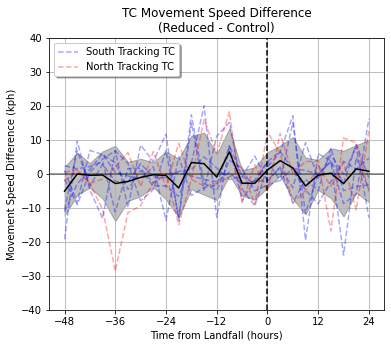

In [45]:
enha_i_spd_red = []
enha_i_spd_inc = []
enha_i_spd_all = []
redu_i_spd_all = []

lim_do = -48
lim_up = 24
label1 = False
label2 = False

for tcname in lf_list.index:
# for tcname in ['BEBINCA']:
    # shift the coordinates to match LF timestep
    o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']))
    e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']))
    r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts']))

    shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
    shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']

    orig_lat = np.array(lf_list.loc[tcname]['lat_o'])
    orig_lon = np.array(lf_list.loc[tcname]['lon_o'])
    enha_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_e']), shift_e)
    enha_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_e']), shift_e)
    redu_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_r']), shift_r)
    redu_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_r']), shift_r)
    

#     orig_lat_next = np.roll(orig_lat,1)
#     orig_lon_next = np.roll(orig_lon, 1)
    
#     redu_lat_next = np.roll(redu_lon_shift, 1)
#     redu_lon_next = np.roll(redu_lon_shift, 1)

#     enha_lat_next = np.roll(enha_lat_shift, 1)
#     enha_lon_next = np.roll(enha_lon_shift, 1)
    
    dist_o_all = []
    dist_e_all = []
    dist_r_all = []    
    
    for i in range(len(orig_lat)-1):
        pt_o = (orig_lat[i], orig_lon[i])
        pt_e = (enha_lat_shift[i], enha_lon_shift[i])
        pt_r = (redu_lat_shift[i], redu_lon_shift[i])
        
        pt_o_n = (orig_lat[i+1], orig_lon[i+1])
        pt_e_n = (enha_lat_shift[i+1], enha_lon_shift[i+1])
        pt_r_n = (redu_lat_shift[i+1], redu_lon_shift[i+1])           
        
        dist_o = geopd.distance(pt_o, pt_o_n).km
        dist_e = geopd.distance(pt_e, pt_e_n).km
        dist_r = geopd.distance(pt_r, pt_r_n).km
        dist_o_all.append(dist_o/3.)
        dist_e_all.append(dist_e/3.)
        dist_r_all.append(dist_r/3.)    
    dist_o_all = np.array(dist_o_all)
    dist_e_all = np.array(dist_e_all)
    dist_r_all = np.array(dist_r_all)
    
    o_t_n = o_t[1:]
    
    o_t_c = o_t_n[(o_t_n<=lim_up) & (o_t_n>=lim_do)]
    dist_o_c = dist_o_all[(o_t_n<=lim_up) & (o_t_n>=lim_do)]
    dist_e_c = dist_e_all[(o_t_n<=lim_up) & (o_t_n>=lim_do)]
    dist_r_c = dist_r_all[(o_t_n<=lim_up) & (o_t_n>=lim_do)]
    
    if tcname in ["IMBUDO", "PRAPIROON"]: 
        if not label1:
            plt.plot(o_t_c, dist_r_c-dist_o_c, 'red', linestyle='--', alpha=0.35, label='North Tracking TC')
            label1 = True
        else:
            plt.plot(o_t_c, dist_r_c-dist_o_c, 'red', linestyle='--', alpha=0.35)            
    else:
        if not label2:
            plt.plot(o_t_c, dist_r_c-dist_o_c, 'blue', linestyle='--', alpha=0.35, label='South Tracking TC')
            label2 = True
        else:
            plt.plot(o_t_c, dist_r_c-dist_o_c, 'blue', linestyle='--', alpha=0.35)    
#     plt.show()
#     print(tcname)
    
    enha_i_spd_all.append(dist_e_c-dist_o_c)
    redu_i_spd_all.append(dist_r_c-dist_o_c)

# o_t_n = o_t[1:]
enha_i_spd_mean = np.array(enha_i_spd_all).mean(axis=0)
enha_i_spd_std = np.array(enha_i_spd_all).std(axis=0)


redu_i_spd_mean = np.array(redu_i_spd_all).mean(axis=0)
redu_i_spd_std = np.array(redu_i_spd_all).std(axis=0)

plt.plot(o_t_c, redu_i_spd_mean, 'black', alpha=1)
plt.fill_between(o_t_c, redu_i_spd_mean-redu_i_spd_std, redu_i_spd_mean+redu_i_spd_std, facecolor='black', color='black', alpha=0.25)
plt.ylabel('Movement Speed Difference (kph)')
plt.xlabel('Time from Landfall (hours)')
plt.ylim(-40, 40)


ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MultipleLocator(12))
fig = plt.gcf()
fig.set_size_inches(6,5)
plt.axvline(x=0, color='k', linestyle='--', alpha=1)
plt.axhline(y=0, color='k', linestyle='-', alpha=.5)
# plt.ylim(-10, 30)
plt.title('TC Movement Speed Difference\n(Reduced - Control)')
plt.grid()
legend = ax.legend(loc='upper left', shadow=True)
# plt.savefig(os.path.join(path_out,'redu_spddiff_colored.png'), bbox_inches='tight', facecolor='white')
plt.show()

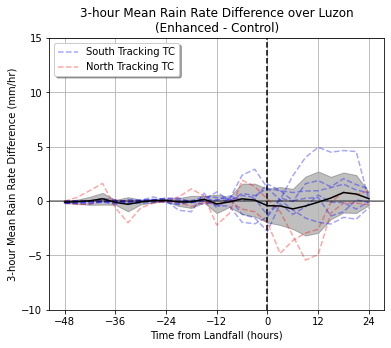

In [8]:
enha_rr_shift_all = []
lim_do = -48
lim_up = 24
# for tcname in ['NESAT']:
# for tcname in ['PRAPIROON']:    
label1 = False
label2 = False
for tcname in lf_list.index:
    o_t = (3*(np.array((range(len(lf_list.loc[tcname]['rain_o']))))-lf_list.loc[tcname]['o_ts']+1))
    e_t = (3*(np.array((range(len(lf_list.loc[tcname]['rain_e']))))-lf_list.loc[tcname]['e_ts']+1))
    r_t = (3*(np.array((range(len(lf_list.loc[tcname]['rain_r']))))-lf_list.loc[tcname]['r_ts']+1)) 
    shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
    shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']    
    orig_rr = np.array(lf_list.loc[tcname]['rain_o'])
    enha_rr_shift = np.roll(np.array(lf_list.loc[tcname]['rain_e']), shift_e)


    if tcname in ["IMBUDO", "PRAPIROON"]: 
        if not label1:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_rr_shift - orig_rr)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', linestyle='--', alpha=0.35, label='North Tracking TC')
            label1 = True
        else:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_rr_shift - orig_rr)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', linestyle='--', alpha=0.35)            
    else:
        if not label2:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_rr_shift - orig_rr)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', linestyle='--', alpha=0.35, label='South Tracking TC')
            label2 = True
        else:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_rr_shift - orig_rr)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', linestyle='--', alpha=0.35)    
    
#     plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_rr_shift - orig_rr)[(o_t<=lim_up) & (o_t>=lim_do)], 'black', linestyle='--', alpha=0.25)
    enha_rr_shift_all.append((enha_rr_shift - orig_rr)[(o_t<=lim_up) & (o_t>=lim_do)])

enha_rr_shift_all_mean = np.array(enha_rr_shift_all).mean(axis=0)
enha_rr_shift_all_std = np.array(enha_rr_shift_all).std(axis=0)
plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], enha_rr_shift_all_mean, 'black', alpha=1)
plt.fill_between(o_t[(o_t<=lim_up) & (o_t>=lim_do)], enha_rr_shift_all_mean-enha_rr_shift_all_std, enha_rr_shift_all_mean+enha_rr_shift_all_std, facecolor='black', color='black', alpha=0.25)
plt.ylabel('3-hour Mean Rain Rate Difference (mm/hr)')
plt.xlabel('Time from Landfall (hours)')

ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MultipleLocator(12))
legend = ax.legend(loc='upper left', shadow=True)

fig = plt.gcf()
fig.set_size_inches(6,5)
plt.axvline(x=0, color='k', linestyle='--', alpha=1)
plt.axhline(y=0, color='k', linestyle='-', alpha=.5)
plt.ylim(-10, 15)
plt.title('3-hour Mean Rain Rate Difference over Luzon\n(Enhanced - Control)')
plt.grid()
# plt.savefig(os.path.join(path_out,'enha_rrdiff_all_colored.png'), bbox_inches='tight', facecolor='white')
plt.show()

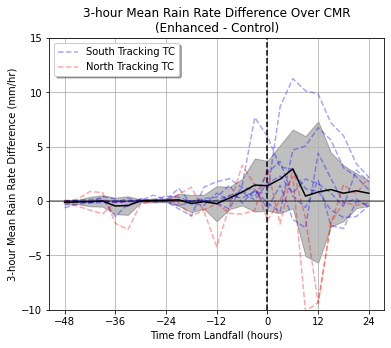

In [61]:
enha_rr_mnt_shift_all = []
lim_do = -48
lim_up = 24
# for tcname in ['NESAT']:
# for tcname in ['PRAPIROON']:    
label1 = False
label2 = False
for tcname in lf_list.index:
    o_t = (3*(np.array((range(len(lf_list.loc[tcname]['rain_mnt_o']))))-lf_list.loc[tcname]['o_ts']+1))
    e_t = (3*(np.array((range(len(lf_list.loc[tcname]['rain_mnt_e']))))-lf_list.loc[tcname]['e_ts']+1))
    r_t = (3*(np.array((range(len(lf_list.loc[tcname]['rain_mnt_r']))))-lf_list.loc[tcname]['r_ts']+1)) 
    shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
    shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']    
    orig_rr_mnt = np.array(lf_list.loc[tcname]['rain_mnt_o'])
    enha_rr_mnt_shift = np.roll(np.array(lf_list.loc[tcname]['rain_mnt_e']), shift_e)
    redu_rr_mnt_shift = np.roll(np.array(lf_list.loc[tcname]['rain_mnt_r']), shift_r)
#     print(tcname)
#     print(len(orig_rr))
#     print(len(enha_rr_shift))
#     print(len(redu_rr_shift))

    
    if tcname in ["IMBUDO", "PRAPIROON"]: 
        if not label1:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_rr_mnt_shift - orig_rr_mnt)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', linestyle='--', alpha=0.35, label='North Tracking TC')
            label1 = True
        else:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_rr_mnt_shift - orig_rr_mnt)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', linestyle='--', alpha=0.35)            
    else:
        if not label2:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_rr_mnt_shift - orig_rr_mnt)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', linestyle='--', alpha=0.35, label='South Tracking TC')
            label2 = True
        else:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_rr_mnt_shift - orig_rr_mnt)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', linestyle='--', alpha=0.35)
    enha_rr_mnt_shift_all.append((enha_rr_mnt_shift - orig_rr_mnt)[(o_t<=lim_up) & (o_t>=lim_do)])
)
enha_rr_mnt_shift_all_mean = np.array(enha_rr_mnt_shift_all).mean(axis=0)
enha_rr_mnt_shift_all_std = np.array(enha_rr_mnt_shift_all).std(axis=0)
plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], enha_rr_mnt_shift_all_mean, 'black', alpha=1)
plt.fill_between(o_t[(o_t<=lim_up) & (o_t>=lim_do)], enha_rr_mnt_shift_all_mean-enha_rr_mnt_shift_all_std, enha_rr_mnt_shift_all_mean+enha_rr_mnt_shift_all_std, facecolor='black', color='black', alpha=0.25)
plt.ylabel('3-hour Mean Rain Rate Difference (mm/hr)')
plt.xlabel('Time from Landfall (hours)')

ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MultipleLocator(12))
legend = ax.legend(loc='upper left', shadow=True)

fig = plt.gcf()
fig.set_size_inches(6,5)
plt.axvline(x=0, color='k', linestyle='--', alpha=1)
plt.axhline(y=0, color='k', linestyle='-', alpha=.5)
plt.ylim(-10, 15)
plt.title('3-hour Mean Rain Rate Difference Over CMR\n(Enhanced - Control)')
plt.grid()
plt.savefig(os.path.join(path_out,'enha_rrmntdiff_all_colored.png'), bbox_inches='tight', facecolor='white')
plt.show()

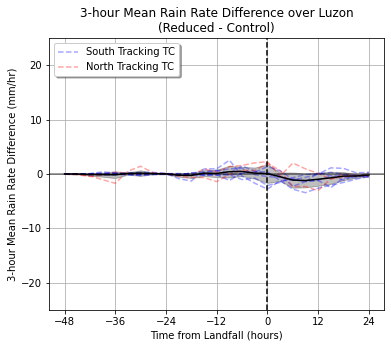

In [10]:
redu_rr_shift_all = []
label1 = False
label2 = False
for tcname in lf_list.index:
    o_t = (3*(np.array((range(len(lf_list.loc[tcname]['rain_o']))))-lf_list.loc[tcname]['o_ts']+1))
    e_t = (3*(np.array((range(len(lf_list.loc[tcname]['rain_e']))))-lf_list.loc[tcname]['e_ts']+1))
    r_t = (3*(np.array((range(len(lf_list.loc[tcname]['rain_r']))))-lf_list.loc[tcname]['r_ts']+1)) 
    shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
    shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']    
    orig_rr = np.array(lf_list.loc[tcname]['rain_o'])
    redu_rr_shift = np.roll(np.array(lf_list.loc[tcname]['rain_r']), shift_r)

    if tcname in ["IMBUDO", "PRAPIROON"]: 
        if not label1:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_rr_shift - orig_rr)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', linestyle='--', alpha=0.35, label='North Tracking TC')
            label1 = True
        else:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_rr_shift - orig_rr)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', linestyle='--', alpha=0.35)            
    else:
        if not label2:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_rr_shift - orig_rr)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', linestyle='--', alpha=0.35, label='South Tracking TC')
            label2 = True
        else:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_rr_shift - orig_rr)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', linestyle='--', alpha=0.35)        
    
#     plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_rr_shift - orig_rr)[(o_t<=lim_up) & (o_t>=lim_do)], 'black', linestyle='--', alpha=0.25)
    redu_rr_shift_all.append((redu_rr_shift - orig_rr)[(o_t<=lim_up) & (o_t>=lim_do)])
redu_rr_shift_all_mean = np.array(redu_rr_shift_all).mean(axis=0)
redu_rr_shift_all_std = np.array(redu_rr_shift_all).std(axis=0)
plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], redu_rr_shift_all_mean, 'black', alpha=1)
plt.fill_between(o_t[(o_t<=lim_up) & (o_t>=lim_do)], redu_rr_shift_all_mean-redu_rr_shift_all_std, redu_rr_shift_all_mean+redu_rr_shift_all_std, facecolor='black', color='black', alpha=0.25)
plt.ylabel('3-hour Mean Rain Rate Difference (mm/hr)')
plt.xlabel('Time from Landfall (hours)')

ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MultipleLocator(12))
legend = ax.legend(loc='upper left', shadow=True)

fig = plt.gcf()
fig.set_size_inches(6,5)
plt.axvline(x=0, color='k', linestyle='--', alpha=1)
plt.axhline(y=0, color='k', linestyle='-', alpha=.5)
plt.ylim(-25, 25)
plt.title('3-hour Mean Rain Rate Difference over Luzon\n(Reduced - Control)')
plt.grid()
# plt.savefig(os.path.join(path_out,'redu_rrdiff_all_colored.png'), bbox_inches='tight', facecolor='white')
plt.show()

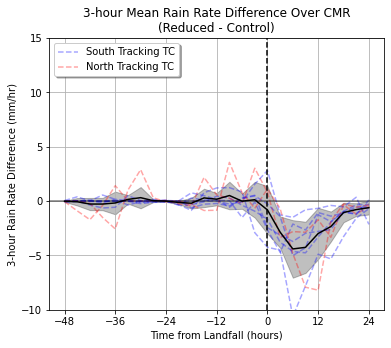

In [62]:
redu_rr_mnt_shift_all = []
lim_do = -48
lim_up = 24
# for tcname in ['NESAT']:
# for tcname in ['PRAPIROON']:
label1 = False
label2 = False
for tcname in lf_list.index:
    o_t = (3*(np.array((range(len(lf_list.loc[tcname]['rain_mnt_o']))))-lf_list.loc[tcname]['o_ts']+1))
    e_t = (3*(np.array((range(len(lf_list.loc[tcname]['rain_mnt_e']))))-lf_list.loc[tcname]['e_ts']+1))
    r_t = (3*(np.array((range(len(lf_list.loc[tcname]['rain_mnt_r']))))-lf_list.loc[tcname]['r_ts']+1)) 
    shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
    shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']    
    orig_rr_mnt = np.array(lf_list.loc[tcname]['rain_mnt_o'])
    redu_rr_mnt_shift = np.roll(np.array(lf_list.loc[tcname]['rain_mnt_e']), shift_e)
    redu_rr_mnt_shift = np.roll(np.array(lf_list.loc[tcname]['rain_mnt_r']), shift_r)
    
    if tcname in ["IMBUDO", "PRAPIROON"]: 
        if not label1:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_rr_mnt_shift - orig_rr_mnt)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', linestyle='--', alpha=0.35, label='North Tracking TC')
            label1 = True
        else:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_rr_mnt_shift - orig_rr_mnt)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', linestyle='--', alpha=0.35)            
    else:
        if not label2:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_rr_mnt_shift - orig_rr_mnt)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', linestyle='--', alpha=0.35, label='South Tracking TC')
            label2 = True
        else:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_rr_mnt_shift - orig_rr_mnt)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', linestyle='--', alpha=0.35)
            
    redu_rr_mnt_shift_all.append((redu_rr_mnt_shift - orig_rr_mnt)[(o_t<=lim_up) & (o_t>=lim_do)])
#     print(tcname)
#     print(len((redu_rr_mnt_shift - orig_rr_mnt)[(o_t<=lim_up) & (o_t>=lim_do)]))
#     print(len((redu_rr_shift - orig_rr)[(o_t<=lim_up) & (o_t>=lim_do)]))
redu_rr_mnt_shift_all_mean = np.array(redu_rr_mnt_shift_all).mean(axis=0)
redu_rr_mnt_shift_all_std = np.array(redu_rr_mnt_shift_all).std(axis=0)
plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], redu_rr_mnt_shift_all_mean, 'black', alpha=1)
plt.fill_between(o_t[(o_t<=lim_up) & (o_t>=lim_do)], redu_rr_mnt_shift_all_mean-redu_rr_mnt_shift_all_std, redu_rr_mnt_shift_all_mean+redu_rr_mnt_shift_all_std, facecolor='black', color='black', alpha=0.25)
plt.ylabel('3-hour Rain Rate Difference (mm/hr)')
plt.xlabel('Time from Landfall (hours)')

ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MultipleLocator(12))
legend = ax.legend(loc='upper left', shadow=True)

fig = plt.gcf()
fig.set_size_inches(6,5)
plt.axvline(x=0, color='k', linestyle='--', alpha=1)
plt.axhline(y=0, color='k', linestyle='-', alpha=.5)
plt.ylim(-10, 15)
plt.title('3-hour Mean Rain Rate Difference Over CMR\n(Reduced - Control)')
plt.grid()
plt.savefig(os.path.join(path_out,'redu_rrmntdiff_all_colored.png'), bbox_inches='tight', facecolor='white')
plt.show()

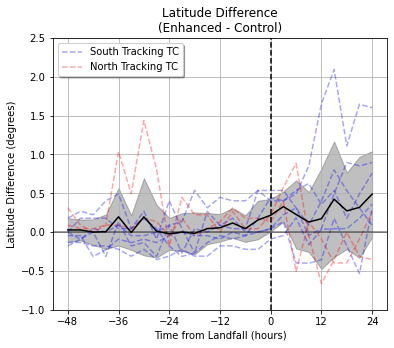

In [64]:
enha_lat_shift_all = []

lim_do = -48
lim_up = 24

label1 = False
label2 = False
for tcname in lf_list.index:
# tcname = 'MEGI'
    o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']))
    e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']))
    r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts']))

    shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
    shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']

    orig_lat = np.array(lf_list.loc[tcname]['lat_o'])
    orig_lon = np.array(lf_list.loc[tcname]['lon_o'])
    enha_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_e']), shift_e)
    enha_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_e']), shift_e)
    redu_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_r']), shift_r)
    redu_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_r']), shift_r)
    
    if tcname in ["IMBUDO", "PRAPIROON"]:     
        if not label1:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_lat_shift - orig_lat)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', linestyle='--', alpha=0.35, label='North Tracking TC')
            label1 = True
        else:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_lat_shift - orig_lat)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', linestyle='--', alpha=0.35)
    else:
        if not label2:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_lat_shift - orig_lat)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', linestyle='--', alpha=0.35, label='South Tracking TC')
            label2 = True
        else:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (enha_lat_shift - orig_lat)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', linestyle='--', alpha=0.35)
    enha_lat_shift_all.append((enha_lat_shift - orig_lat)[(o_t<=lim_up) & (o_t>=lim_do)])
#     print(tcname)
#     print(len((enha_lat_shift - orig_lat)[(o_t<=lim_up) & (o_t>=lim_do)]))
enha_lat_shift_all_mean = np.array(enha_lat_shift_all).mean(axis=0)
enha_lat_shift_all_std = np.array(enha_lat_shift_all).std(axis=0)

plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], enha_lat_shift_all_mean, 'black', alpha=1)
plt.fill_between(o_t[(o_t<=lim_up) & (o_t>=lim_do)], enha_lat_shift_all_mean-enha_lat_shift_all_std, enha_lat_shift_all_mean+enha_lat_shift_all_std, facecolor='black', color='black', alpha=0.25)
# plt.ylabel('Latitude Difference ($^\circ$)')
plt.ylabel('Latitude Difference (degrees)')
plt.title('Latitude Difference\n(Enhanced - Control)')
plt.xlabel('Time from Landfall (hours)')

ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MultipleLocator(12))
legend = ax.legend(loc='upper left', shadow=True)

fig = plt.gcf()
fig.set_size_inches(6,5)
plt.axvline(x=0, color='k', linestyle='--', alpha=1)
plt.axhline(y=0, color='k', linestyle='-', alpha=.5)
plt.ylim(-1, 2.5)
plt.grid()
# plt.savefig(os.path.join(path_out,'enha_latdiff_all_colored.png'), bbox_inches='tight', facecolor='white')
plt.show()

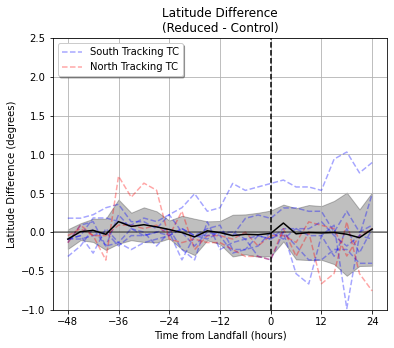

In [65]:
redu_lat_shift_all = []

lim_do = -48
lim_up = 24
label1 = False
label2 = False
for tcname in lf_list.index:
# tcname = 'MEGI'
    o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']))
    e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']))
    r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts']))

    shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
    shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']

    orig_lat = np.array(lf_list.loc[tcname]['lat_o'])
    orig_lon = np.array(lf_list.loc[tcname]['lon_o'])
    enha_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_e']), shift_e)
    enha_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_e']), shift_e)
    redu_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_r']), shift_r)
    redu_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_r']), shift_r)

    if tcname in ["IMBUDO", "PRAPIROON"]:     
        if not label1:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_lat_shift - orig_lat)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', linestyle='--', alpha=0.35, label='North Tracking TC')
            label1 = True
        else:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_lat_shift - orig_lat)[(o_t<=lim_up) & (o_t>=lim_do)], 'red', linestyle='--', alpha=0.35)
    else:
        if not label2:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_lat_shift - orig_lat)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', linestyle='--', alpha=0.35, label='South Tracking TC')
            label2 = True
        else:
            plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], (redu_lat_shift - orig_lat)[(o_t<=lim_up) & (o_t>=lim_do)], 'blue', linestyle='--', alpha=0.35)    
    
    redu_lat_shift_all.append((redu_lat_shift - orig_lat)[(o_t<=lim_up) & (o_t>=lim_do)])
#     print(tcname)
#     print(len((enha_lat_shift - orig_lat)[(o_t<=lim_up) & (o_t>=lim_do)]))
redu_lat_shift_all_mean = np.array(redu_lat_shift_all).mean(axis=0)
redu_lat_shift_all_std = np.array(redu_lat_shift_all).std(axis=0)

plt.plot(o_t[(o_t<=lim_up) & (o_t>=lim_do)], redu_lat_shift_all_mean, 'black', alpha=1)
plt.fill_between(o_t[(o_t<=lim_up) & (o_t>=lim_do)], redu_lat_shift_all_mean-redu_lat_shift_all_std, redu_lat_shift_all_mean+redu_lat_shift_all_std, facecolor='black', color='black', alpha=0.25)
# plt.ylabel('Latitude Difference ($^\circ$)')
plt.ylabel('Latitude Difference (degrees)')
plt.title('Latitude Difference\n(Reduced - Control)')
plt.xlabel('Time from Landfall (hours)')

ax = plt.gca()
ax.xaxis.set_major_locator(mticker.MultipleLocator(12))
legend = ax.legend(loc='upper left', shadow=True)

fig = plt.gcf()
fig.set_size_inches(6,5)
plt.axvline(x=0, color='k', linestyle='--', alpha=1)
plt.axhline(y=0, color='k', linestyle='-', alpha=.5)
plt.ylim(-1, 2.5)
plt.grid()
plt.savefig(os.path.join(path_out,'redu_latdiff_all_colored.png'), bbox_inches='tight', facecolor='white')
plt.show()

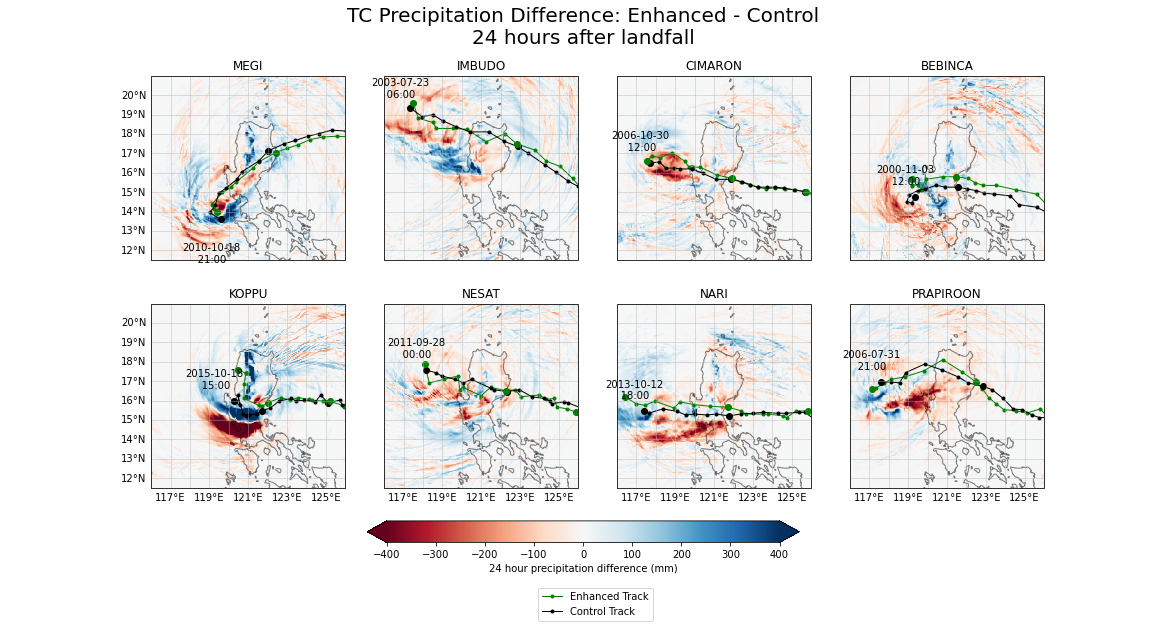

In [12]:
# TC Gallery
v_val = 400

lim_do = -48
lim_up = 24

plt.clf()
plt.close('all')

fig, axes = plt.subplots(nrows=2,
                         ncols=4,
                         facecolor='white',
                         figsize=(16,8),
                         subplot_kw={'projection': crs})
i = -1
for j in range(0,2):
    for k in range(0,4):
        i+=1
        tcname = lf_list.index.values[i]
        tc_ts_o = lf_list.loc[tcname].o_ts
        if tcname=='IMBUDO':
            tc_ts_o = tc_ts_o + 1
        tc_path = os.path.join(wrf_path_base,tcname.lower()+'_'+'orig')
        tc_list_o = os.listdir(tc_path)
        for wrf_ncs_o in tc_list_o:
            if wrf_ncs_o[0:10]=='wrfout_d02':
                wrf_nc_o = wrf_ncs_o
        tc_nc_path_o = os.path.join(tc_path, wrf_nc_o)

        ncfile_o = Dataset(tc_nc_path_o)
        uv10_o = getvar(ncfile_o, "uvmet10", units="kt", timeidx=tc_ts_o+8)
        ua_1km_o = getvar(ncfile_o, "ua", units="kt", timeidx=tc_ts_o)[7]
        va_1km_o = getvar(ncfile_o, "va", units="kt", timeidx=tc_ts_o)[7]  
        rainnc_24_o = (ncfile_o['RAINNC'][tc_ts_o+8]+ncfile_o['RAINC'][tc_ts_o+8]) - (ncfile_o['RAINNC'][tc_ts_o]+ncfile_o['RAINC'][tc_ts_o])

        # ENHANCED
        tc_ts_e = lf_list.loc[tcname].e_ts
        # if tcname=='IMBUDO':
        #     tc_ts_e = tc_ts_e + 1      
        tc_path = os.path.join(wrf_path_base,tcname.lower()+'_'+'enha')
        tc_list_e = os.listdir(tc_path)
        for wrf_ncs_e in tc_list_e:
            if wrf_ncs_e[0:10]=='wrfout_d02':
                wrf_nc_e = wrf_ncs_e
        tc_nc_path_e = os.path.join(tc_path, wrf_nc_e)

        ncfile_e = Dataset(tc_nc_path_e)
        uv10_e = getvar(ncfile_e, "uvmet10", units="kt", timeidx=tc_ts_e+8)
        ua_1km_e = getvar(ncfile_e, "ua", units="kt", timeidx=tc_ts_e)[7]
        va_1km_e = getvar(ncfile_e, "va", units="kt", timeidx=tc_ts_e)[7]  
        rainnc_24_e = (ncfile_e['RAINNC'][tc_ts_e+8]+ncfile_e['RAINC'][tc_ts_e+8]) - (ncfile_e['RAINNC'][tc_ts_e]+ncfile_e['RAINC'][tc_ts_e])
        rainnc_3_e = ncfile_e['RAINNC'][tc_ts_e] - ncfile_e['RAINNC'][tc_ts_e-1]
        time_str = str(uv10_o.Time.values)[0:10] + '\n     ' + str(uv10_o.Time.values)[11:16]


        lats, lons = latlon_coords(uv10_e)

        # Get the tracks
        # if tcname == "IMBUDO":
        #     o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']-1))
        #     e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']-1))
        #     r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts']-1))
        # else:
        o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']))
        e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']))
        r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts']))


        shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
        shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']

        orig_lat = np.array(lf_list.loc[tcname]['lat_o'])
        orig_lon = np.array(lf_list.loc[tcname]['lon_o'])
        enha_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_e']), shift_e)
        enha_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_e']), shift_e)
        redu_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_r']), shift_r)
        redu_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_r']), shift_r)


        o_t_24 = o_t[(o_t<=lim_up) & (o_t>=lim_do)]
        orig_lat_24 = orig_lat[(o_t<=lim_up) & (o_t>=lim_do)]
        orig_lon_24 = orig_lon[(o_t<=lim_up) & (o_t>=lim_do)]
        redu_lat_24 = redu_lat_shift[(o_t<=lim_up) & (o_t>=lim_do)]
        redu_lon_24 = redu_lon_shift[(o_t<=lim_up) & (o_t>=lim_do)]
        enha_lat_24 = enha_lat_shift[(o_t<=lim_up) & (o_t>=lim_do)]
        enha_lon_24 = enha_lon_shift[(o_t<=lim_up) & (o_t>=lim_do)]
        

        # plot
        axes[j,k].coastlines(resolution='10m', alpha=.5)
        gl = axes[j,k].gridlines(crs=crs, draw_labels=True, alpha=0.5)
        gl.top_labels = None
        gl.right_labels = None
        
        if k>=1:
            gl.left_labels = None
        if j==0:
            gl.bottom_labels = None
        
        xgrid = np.arange(lon_min-10, lon_max+10, 1)
        ygrid = np.arange(lat_min-10, lat_max+10, 1)
        gl.xlocator = mticker.FixedLocator(xgrid.tolist())
        gl.ylocator = mticker.FixedLocator(ygrid.tolist())
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 10, 'color': 'black'}
        gl.ylabel_style = {'size': 10, 'color': 'black'}
        
        plot_rain = axes[j,k].pcolormesh(lons, lats, (rainnc_24_e - rainnc_24_o), cmap='RdBu', vmin=-v_val, vmax=v_val)
        plot_track_e, = axes[j,k].plot(enha_lon_24, enha_lat_24, 'go-', label='Enhanced Track', linewidth=1, markersize=3)
        plot_track_o, = axes[j,k].plot(orig_lon_24, orig_lat_24, 'ko-', label='Control Track', linewidth=1, markersize=3)
        axes[j,k].plot(orig_lon_24[::8], orig_lat_24[::8], 'ko', linewidth=1, markersize=6) 
        axes[j,k].plot(enha_lon_24[::8], enha_lat_24[::8], 'go', linewidth=1, markersize=6)         
        if tcname=='MEGI':
            axes[j,k].text(orig_lon_24[-1]-2, orig_lat_24[-1]-2.2, time_str, size=10)
        elif tcname=='KOPPU':
            axes[j,k].text(orig_lon_24[-1]-2.5, orig_lat_24[-1]+.65, time_str, size=10)
        elif tcname=='IMBUDO':
            axes[j,k].text(orig_lon_24[-1]-2, orig_lat_24[-1]+.55, time_str, size=10)                 
        else:
            axes[j,k].text(orig_lon_24[-1]-2, orig_lat_24[-1]+.65, time_str, size=10)         
            
        axes[j,k].set_xlim((116, 126))
        axes[j,k].set_ylim((13.5-2, 19+2))
        # axes[j,k].set_xlim((119, 123))
        # axes[j,k].set_ylim((15, 19))        
        axes[j,k].set_title(tcname)
        

fig.suptitle('TC Precipitation Difference: Enhanced - Control\n24 hours after landfall', size=20)
fig.legend((plot_track_e, plot_track_o), ('Enhanced Track', 'Control Track'), bbox_to_anchor=(0.565, -0.02))
fig.subplots_adjust(hspace=0.1)
# cbar_ax = fig.add_axes([0, 0.0, 1.0, 0.25], facecolor='none')
cbar_ax = fig.add_axes([0., 0.05, 1.0, 0.25], facecolor='none')
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
cbar = fig.colorbar(plot_rain, orientation='horizontal', ax=cbar_ax, pad=1, extend='both')
cbar.ax.set_xlabel('24 hour precipitation difference (mm)')
plt.savefig(os.path.join(path_out, 'enhactrl_precdiff.png'), bbox_inches='tight', facecolor='white', dpi=300)
plt.show()

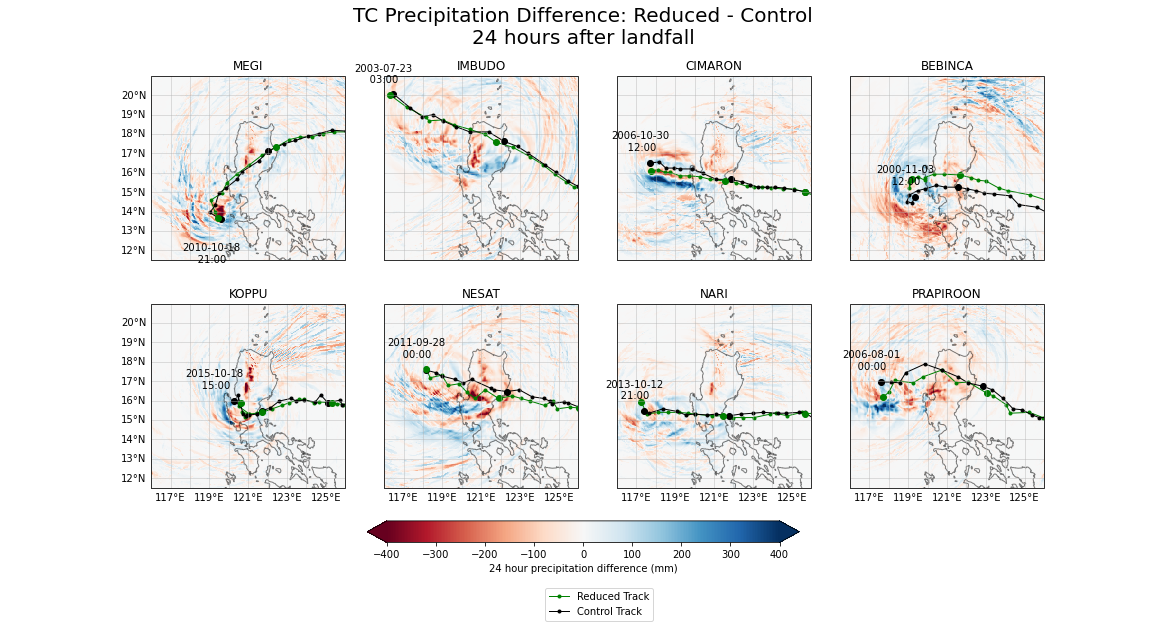

In [13]:
# TC Gallery
v_val = 400

plt.clf()
plt.close('all')

fig, axes = plt.subplots(nrows=2,
                         ncols=4,
                         facecolor='white',
                         figsize=(16,8),
                         subplot_kw={'projection': crs})
i = -1
for j in range(0,2):
    for k in range(0,4):
        i+=1
        tcname = lf_list.index.values[i]
        tc_ts_o = lf_list.loc[tcname].e_ts
        tc_path = os.path.join(wrf_path_base,tcname.lower()+'_'+'orig')
        tc_list_o = os.listdir(tc_path)
        for wrf_ncs_o in tc_list_o:
            if wrf_ncs_o[0:10]=='wrfout_d02':
                wrf_nc_o = wrf_ncs_o
        tc_nc_path_o = os.path.join(tc_path, wrf_nc_o)

        ncfile_o = Dataset(tc_nc_path_o)
        uv10_o = getvar(ncfile_o, "uvmet10", units="kt", timeidx=tc_ts_o)
        ua_1km_o = getvar(ncfile_o, "ua", units="kt", timeidx=tc_ts_o)[7]
        va_1km_o = getvar(ncfile_o, "va", units="kt", timeidx=tc_ts_o)[7]  
        rainnc_24_o= (ncfile_o['RAINNC'][tc_ts_o+8]+ncfile_o['RAINC'][tc_ts_o+8]) - (ncfile_o['RAINNC'][tc_ts_o]+ncfile_o['RAINC'][tc_ts_o])


        # REDUCED
        tc_ts_r = lf_list.loc[tcname].e_ts
        tc_path = os.path.join(wrf_path_base,tcname.lower()+'_'+'redu')
        tc_list_r = os.listdir(tc_path)
        for wrf_ncs_r in tc_list_r:
            if wrf_ncs_r[0:10]=='wrfout_d02':
                wrf_nc_r = wrf_ncs_r
        tc_nc_path_r = os.path.join(tc_path, wrf_nc_r)

        ncfile_r = Dataset(tc_nc_path_r)
        uv10_r = getvar(ncfile_r, "uvmet10", units="kt", timeidx=tc_ts_r+8)
        ua_1km_r = getvar(ncfile_r, "ua", units="kt", timeidx=tc_ts_r)[7]
        va_1km_r = getvar(ncfile_r, "va", units="kt", timeidx=tc_ts_r)[7]  
        rainnc_24_r = (ncfile_r['RAINNC'][tc_ts_r+8]+ ncfile_r['RAINC'][tc_ts_r+8]) - (ncfile_r['RAINNC'][tc_ts_r]+ncfile_r['RAINC'][tc_ts_r])
        time_str = str(uv10_r.Time.values)[0:10] + '\n     ' + str(uv10_r.Time.values)[11:16]
        lats, lons = latlon_coords(uv10_e)

        # Get the tracks

        if tcname == "IMBUDO":
            o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']-1))
            e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']-1))
            r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts']-1))
        else:
            o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']))
            e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']))
            r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts']))


        shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
        shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']

        orig_lat = np.array(lf_list.loc[tcname]['lat_o'])
        orig_lon = np.array(lf_list.loc[tcname]['lon_o'])
        enha_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_e']), shift_e)
        enha_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_e']), shift_e)
        redu_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_r']), shift_r)
        redu_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_r']), shift_r)


        o_t_24 = o_t[(o_t<=lim_up) & (o_t>=lim_do)]
        orig_lat_24 = orig_lat[(o_t<=lim_up) & (o_t>=lim_do)]
        orig_lon_24 = orig_lon[(o_t<=lim_up) & (o_t>=lim_do)]
        redu_lat_24 = redu_lat_shift[(o_t<=lim_up) & (o_t>=lim_do)]
        redu_lon_24 = redu_lon_shift[(o_t<=lim_up) & (o_t>=lim_do)]
        enha_lat_24 = enha_lat_shift[(o_t<=lim_up) & (o_t>=lim_do)]
        enha_lon_24 = enha_lon_shift[(o_t<=lim_up) & (o_t>=lim_do)]

        # plot
        axes[j,k].coastlines(resolution='10m', alpha=.5)
        gl = axes[j,k].gridlines(crs=crs, draw_labels=True, alpha=0.5)
        gl.top_labels = None
        gl.right_labels = None
        
        if k>=1:
            gl.left_labels = None
        if j==0:
            gl.bottom_labels = None
        
        xgrid = np.arange(lon_min-10, lon_max+10, 1)
        ygrid = np.arange(lat_min-10, lat_max+10, 1)
        gl.xlocator = mticker.FixedLocator(xgrid.tolist())
        gl.ylocator = mticker.FixedLocator(ygrid.tolist())
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 10, 'color': 'black'}
        gl.ylabel_style = {'size': 10, 'color': 'black'}
        
        plot_rain = axes[j,k].pcolormesh(lons, lats, (rainnc_24_r - rainnc_24_o), cmap='RdBu', vmin=-v_val, vmax=v_val)
        plot_track_r, = axes[j,k].plot(redu_lon_24, redu_lat_24, 'go-', label='Reduced Track', linewidth=1, markersize=3)
        plot_track_o, = axes[j,k].plot(orig_lon_24, orig_lat_24, 'ko-', label='Control Track', linewidth=1, markersize=3)

        if tcname=='MEGI':
            axes[j,k].text(orig_lon_24[-1]-2, orig_lat_24[-1]-2.2, time_str, size=10)
        elif tcname=='KOPPU':
            axes[j,k].text(orig_lon_24[-1]-2.5, orig_lat_24[-1]+.65, time_str, size=10)
        elif tcname=='IMBUDO':
            axes[j,k].text(orig_lon_24[-1]-2, orig_lat_24[-1]+.55, time_str, size=10)                 
        else:
            axes[j,k].text(orig_lon_24[-1]-2, orig_lat_24[-1]+.65, time_str, size=10)         

        
        axes[j,k].plot(orig_lon_24[::8], orig_lat_24[::8], 'ko', linewidth=1, markersize=6) 
        axes[j,k].plot(redu_lon_24[::8], redu_lat_24[::8], 'go', linewidth=1, markersize=6)             
        
        axes[j,k].set_xlim((116, 126))
        axes[j,k].set_ylim((13.5-2, 19+2))
        # axes[j,k].set_xlim((119, 123))
        # axes[j,k].set_ylim((15, 19))  
        axes[j,k].set_title(tcname)
        
            
            
fig.suptitle('TC Precipitation Difference: Reduced - Control\n24 hours after landfall', size=20)
fig.legend((plot_track_r, plot_track_o), ('Reduced Track', 'Control Track'), bbox_to_anchor=(0.565, -0.02))
fig.subplots_adjust(hspace=0.1)
# cbar_ax = fig.add_axes([0, 0.0, 1.0, 0.25], facecolor='none')
cbar_ax = fig.add_axes([0., 0.05, 1.0, 0.25], facecolor='none')
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
cbar = fig.colorbar(plot_rain, orientation='horizontal', ax=cbar_ax, pad=1, extend='both')
cbar.ax.set_xlabel('24 hour precipitation difference (mm)')
plt.savefig(os.path.join(path_out, 'reductrl_precdiff.png'), bbox_inches='tight', facecolor='white', dpi=300)
plt.show()

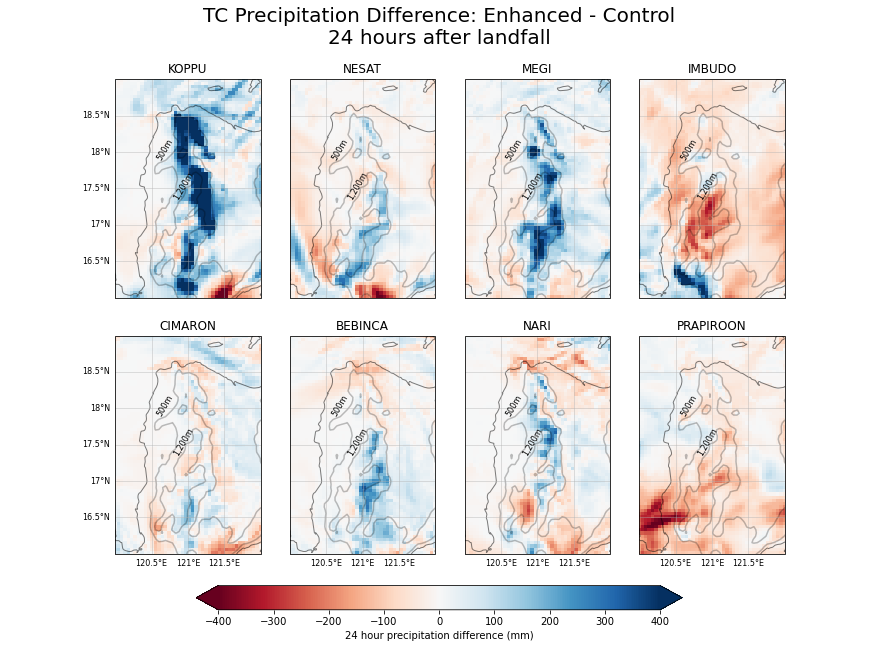

In [139]:
# TC Gallery
v_val = 400

lim_do = -48
lim_up = 24

plt.clf()
plt.close('all')

fig, axes = plt.subplots(nrows=2,
                         ncols=4,
                         facecolor='white',
                         figsize=(12,9),
                         subplot_kw={'projection': crs})
i = -1
for j in range(0,2):
    for k in range(0,4):
        i+=1
        tcname = lf_list.index.values[i]
        tc_ts_o = lf_list.loc[tcname].o_ts
        tc_path = os.path.join(wrf_path_base,tcname.lower()+'_'+'orig')
        tc_list_o = os.listdir(tc_path)
        for wrf_ncs_o in tc_list_o:
            if wrf_ncs_o[0:10]=='wrfout_d02':
                wrf_nc_o = wrf_ncs_o
        tc_nc_path_o = os.path.join(tc_path, wrf_nc_o)

        ncfile_o = Dataset(tc_nc_path_o)
        uv10_o = getvar(ncfile_o, "uvmet10", units="kt", timeidx=tc_ts_o+8)
        ua_1km_o = getvar(ncfile_o, "ua", units="kt", timeidx=tc_ts_o)[7]
        va_1km_o = getvar(ncfile_o, "va", units="kt", timeidx=tc_ts_o)[7]  
        rainnc_24_o= (ncfile_o['RAINNC'][tc_ts_o+8]+ncfile_o['RAINC'][tc_ts_o+8]) - (ncfile_o['RAINNC'][tc_ts_o]+ncfile_o['RAINC'][tc_ts_o])


        # ENHANCED
        tc_ts_e = lf_list.loc[tcname].e_ts
        if tcname=='IMBUDO':
            tc_ts_e = tc_ts_e + 1      
        tc_path = os.path.join(wrf_path_base,tcname.lower()+'_'+'enha')
        tc_list_e = os.listdir(tc_path)
        for wrf_ncs_e in tc_list_e:
            if wrf_ncs_e[0:10]=='wrfout_d02':
                wrf_nc_e = wrf_ncs_e
        tc_nc_path_e = os.path.join(tc_path, wrf_nc_e)

        ncfile_e = Dataset(tc_nc_path_e)
        uv10_e = getvar(ncfile_e, "uvmet10", units="kt", timeidx=tc_ts_e+8)
        ua_1km_e = getvar(ncfile_e, "ua", units="kt", timeidx=tc_ts_e)[7]
        va_1km_e = getvar(ncfile_e, "va", units="kt", timeidx=tc_ts_e)[7]  
        hgt_m = getvar(ncfile_o, "ter", timeidx=tc_ts_o)             
        rainnc_24_e = (ncfile_e['RAINNC'][tc_ts_e+8]+ncfile_e['RAINC'][tc_ts_e+8]) - (ncfile_e['RAINNC'][tc_ts_e]+ncfile_e['RAINC'][tc_ts_e])
        time_str = str(uv10_o.Time.values)[0:10] + '\n     ' + str(uv10_o.Time.values)[11:16]


        lats, lons = latlon_coords(uv10_e)

        # Get the tracks
        o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']))
        e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']))
        r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts']))
        shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
        shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']

        orig_lat = np.array(lf_list.loc[tcname]['lat_o'])
        orig_lon = np.array(lf_list.loc[tcname]['lon_o'])
        enha_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_e']), shift_e)
        enha_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_e']), shift_e)
        redu_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_r']), shift_r)
        redu_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_r']), shift_r)


        o_t_24 = o_t[(o_t<=lim_up) & (o_t>=lim_do)]
        orig_lat_24 = orig_lat[(o_t<=lim_up) & (o_t>=lim_do)]
        orig_lon_24 = orig_lon[(o_t<=lim_up) & (o_t>=lim_do)]
        redu_lat_24 = redu_lat_shift[(o_t<=lim_up) & (o_t>=lim_do)]
        redu_lon_24 = redu_lon_shift[(o_t<=lim_up) & (o_t>=lim_do)]
        enha_lat_24 = enha_lat_shift[(o_t<=lim_up) & (o_t>=lim_do)]
        enha_lon_24 = enha_lon_shift[(o_t<=lim_up) & (o_t>=lim_do)]
        

        # plot
        axes[j,k].coastlines(resolution='10m', alpha=.5)
        gl = axes[j,k].gridlines(crs=crs, draw_labels=True, alpha=0.5)
        gl.top_labels = None
        gl.right_labels = None
        
        if k>=1:
            gl.left_labels = None
        if j==0:
            gl.bottom_labels = None
        
        xgrid = np.arange(lon_min-10, lon_max+10, 0.5)
        ygrid = np.arange(lat_min-10, lat_max+10, 0.5)
        gl.xlocator = mticker.FixedLocator(xgrid.tolist())
        gl.ylocator = mticker.FixedLocator(ygrid.tolist())
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 8, 'color': 'black'}
        gl.ylabel_style = {'size': 8, 'color': 'black'}
        
        plot_rain = axes[j,k].pcolormesh(lons, lats, (rainnc_24_e - rainnc_24_o), cmap='RdBu', vmin=-v_val, vmax=v_val)
        plot_hgt = axes[j,k].contour(lons, lats, hgt_m, labels, alpha=0.25, colors='black')
        axes[j,k].text(120.55,17.89, '500m', rotation=60,size=8)
        axes[j,k].text(120.78,17.35, '1,200m', rotation=60,size=8)    
        axes[j,k].set_xlim((120, 122))
        # axes[j,k].set_ylim((15, 19))         
        axes[j,k].set_ylim((16, 19))      
        axes[j,k].set_title(tcname)
        

fig.suptitle('TC Precipitation Difference: Enhanced - Control\n24 hours after landfall', size=20)
# fig.legend((plot_track_e, plot_track_o), ('Enhanced Track', 'Control Track'), bbox_to_anchor=(0.565, -0.02))
fig.subplots_adjust(hspace=0.1)
# cbar_ax = fig.add_axes([0, 0.0, 1.0, 0.25], facecolor='none')
cbar_ax = fig.add_axes([0., 0.05, 1.0, 0.25], facecolor='none')
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
cbar = fig.colorbar(plot_rain, orientation='horizontal', ax=cbar_ax, pad=1, extend='both')
cbar.ax.set_xlabel('24 hour precipitation difference (mm)')
plt.savefig(os.path.join(path_out, 'enhactrl_precdiff_zoom.png'), bbox_inches='tight', facecolor='white', dpi=300)
plt.show()

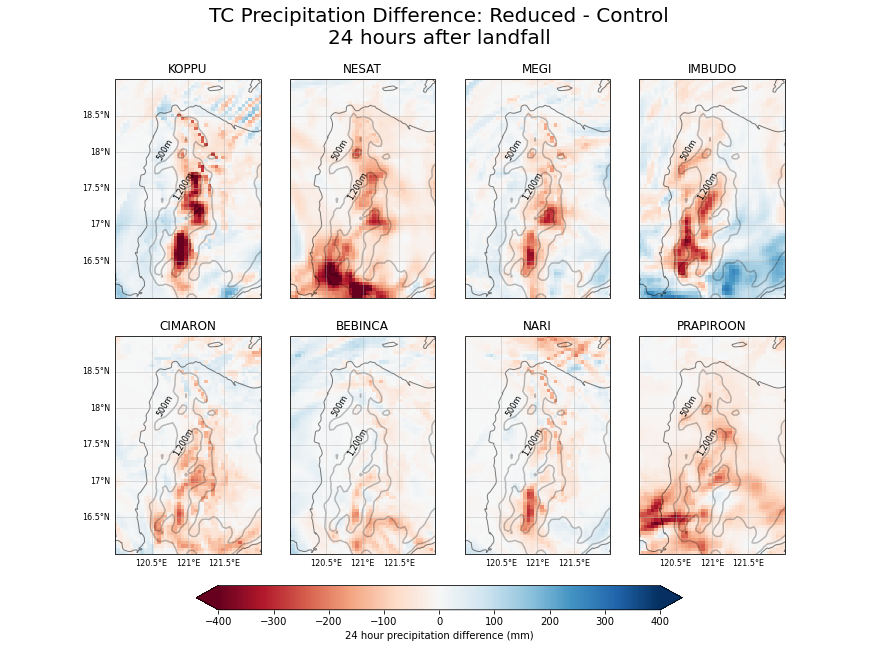

In [140]:
# TC Gallery
v_val = 400

plt.clf()
plt.close('all')

fig, axes = plt.subplots(nrows=2,
                         ncols=4,
                         facecolor='white',
                         figsize=(12,9),
                         subplot_kw={'projection': crs})
i = -1
for j in range(0,2):
    for k in range(0,4):
        i+=1
        tcname = lf_list.index.values[i]
        tc_ts_o = lf_list.loc[tcname].e_ts
        tc_path = os.path.join(wrf_path_base,tcname.lower()+'_'+'orig')
        tc_list_o = os.listdir(tc_path)
        for wrf_ncs_o in tc_list_o:
            if wrf_ncs_o[0:10]=='wrfout_d02':
                wrf_nc_o = wrf_ncs_o
        tc_nc_path_o = os.path.join(tc_path, wrf_nc_o)

        ncfile_o = Dataset(tc_nc_path_o)
        uv10_o = getvar(ncfile_o, "uvmet10", units="kt", timeidx=tc_ts_o)
        ua_1km_o = getvar(ncfile_o, "ua", units="kt", timeidx=tc_ts_o)[7]
        va_1km_o = getvar(ncfile_o, "va", units="kt", timeidx=tc_ts_o)[7]  
        hgt_m = getvar(ncfile_o, "ter", timeidx=tc_ts_o)        
        rainnc_24_o = (ncfile_o['RAINNC'][tc_ts_o+8]+ncfile_o['RAINC'][tc_ts_o+8]) - (ncfile_o['RAINNC'][tc_ts_o]+ncfile_o['RAINC'][tc_ts_o])


        # REDUCED
        tc_ts_r = lf_list.loc[tcname].e_ts
        tc_path = os.path.join(wrf_path_base,tcname.lower()+'_'+'redu')
        tc_list_r = os.listdir(tc_path)
        for wrf_ncs_r in tc_list_r:
            if wrf_ncs_r[0:10]=='wrfout_d02':
                wrf_nc_r = wrf_ncs_r
        tc_nc_path_r = os.path.join(tc_path, wrf_nc_r)

        ncfile_r = Dataset(tc_nc_path_r)
        uv10_r = getvar(ncfile_r, "uvmet10", units="kt", timeidx=tc_ts_r+8)
        ua_1km_r = getvar(ncfile_r, "ua", units="kt", timeidx=tc_ts_r)[7]
        va_1km_r = getvar(ncfile_r, "va", units="kt", timeidx=tc_ts_r)[7]  
        rainnc_24_r = (ncfile_r['RAINNC'][tc_ts_r+8]+ncfile_r['RAINC'][tc_ts_r+8]) - (ncfile_r['RAINNC'][tc_ts_r]+ncfile_r['RAINC'][tc_ts_r])
        time_str = str(uv10_r.Time.values)[0:10] + '\n     ' + str(uv10_r.Time.values)[11:16]
        lats, lons = latlon_coords(uv10_r)

        # Get the tracks

        if tcname == "IMBUDO":
            o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']-1))
            e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']-1))
            r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts']-1))
        else:
            o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']))
            e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']))
            r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts']))


        shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
        shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']

        orig_lat = np.array(lf_list.loc[tcname]['lat_o'])
        orig_lon = np.array(lf_list.loc[tcname]['lon_o'])
        enha_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_e']), shift_e)
        enha_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_e']), shift_e)
        redu_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_r']), shift_r)
        redu_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_r']), shift_r)


        o_t_24 = o_t[(o_t<=lim_up) & (o_t>=lim_do)]
        orig_lat_24 = orig_lat[(o_t<=lim_up) & (o_t>=lim_do)]
        orig_lon_24 = orig_lon[(o_t<=lim_up) & (o_t>=lim_do)]
        redu_lat_24 = redu_lat_shift[(o_t<=lim_up) & (o_t>=lim_do)]
        redu_lon_24 = redu_lon_shift[(o_t<=lim_up) & (o_t>=lim_do)]
        enha_lat_24 = enha_lat_shift[(o_t<=lim_up) & (o_t>=lim_do)]
        enha_lon_24 = enha_lon_shift[(o_t<=lim_up) & (o_t>=lim_do)]

        # plot
        axes[j,k].coastlines(resolution='10m', alpha=.5)
        gl = axes[j,k].gridlines(crs=crs, draw_labels=True, alpha=0.5)
        gl.top_labels = None
        gl.right_labels = None
        
        if k>=1:
            gl.left_labels = None
        if j==0:
            gl.bottom_labels = None
        
        xgrid = np.arange(lon_min-10, lon_max+10, 0.5)
        ygrid = np.arange(lat_min-10, lat_max+10, 0.5)
        gl.xlocator = mticker.FixedLocator(xgrid.tolist())
        gl.ylocator = mticker.FixedLocator(ygrid.tolist())
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 8, 'color': 'black'}
        gl.ylabel_style = {'size': 8, 'color': 'black'}
        
        plot_rain = axes[j,k].pcolormesh(lons, lats, (rainnc_24_r - rainnc_24_o), cmap='RdBu', vmin=-v_val, vmax=v_val)
        labels = [500,1200]
        plot_hgt = axes[j,k].contour(lons, lats, hgt_m, labels, alpha=0.25, colors='black')
        axes[j,k].text(120.55,17.89, '500m', rotation=60,size=8)
        axes[j,k].text(120.78,17.35, '1,200m', rotation=60,size=8)        
        axes[j,k].set_xlim((120, 122))     
        axes[j,k].set_ylim((16, 19))  
        axes[j,k].set_title(tcname)
        
            
            
fig.suptitle('TC Precipitation Difference: Reduced - Control\n24 hours after landfall', size=20)
# fig.legend((plot_track_r, plot_track_o), ('Reduced Track', 'Control Track'), bbox_to_anchor=(0.565, -0.02))
fig.subplots_adjust(hspace=0.1)
# cbar_ax = fig.add_axes([0, 0.0, 1.0, 0.25], facecolor='none')
cbar_ax = fig.add_axes([0., 0.05, 1.0, 0.25], facecolor='none')
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
cbar = fig.colorbar(plot_rain, orientation='horizontal', ax=cbar_ax, pad=1, extend='both')
cbar.ax.set_xlabel('24 hour precipitation difference (mm)')
plt.savefig(os.path.join(path_out, 'reductrl_precdiff_zoom.png'), bbox_inches='tight', facecolor='white', dpi=300)
plt.show()

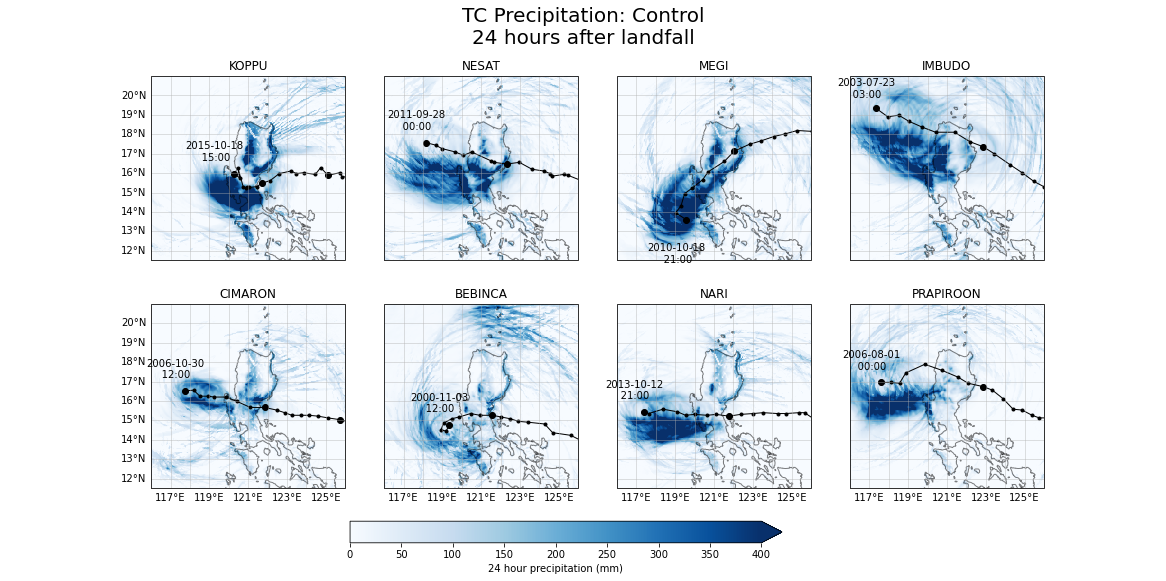

In [79]:
# TC Gallery
v_val = 400

plt.clf()
plt.close('all')

fig, axes = plt.subplots(nrows=2,
                         ncols=4,
                         facecolor='white',
                         figsize=(16,8),
                         subplot_kw={'projection': crs})
i = -1

lim_do = -48
lim_up = 24

for j in range(0,2):
    for k in range(0,4):
        i+=1
        tcname = lf_list.index.values[i]
        tc_ts_o = lf_list.loc[tcname].e_ts
        tc_path = os.path.join(wrf_path_base,tcname.lower()+'_'+'orig')
        tc_list_o = os.listdir(tc_path)
        for wrf_ncs_o in tc_list_o:
            if wrf_ncs_o[0:10]=='wrfout_d02':
                wrf_nc_o = wrf_ncs_o
        tc_nc_path_o = os.path.join(tc_path, wrf_nc_o)

        ncfile_o = Dataset(tc_nc_path_o)
        uv10_o = getvar(ncfile_o, "uvmet10", units="kt", timeidx=tc_ts_o+8)
        ua_1km_o = getvar(ncfile_o, "ua", units="kt", timeidx=tc_ts_o)[7]
        va_1km_o = getvar(ncfile_o, "va", units="kt", timeidx=tc_ts_o)[7]
        hgt_m = getvar(ncfile_o, "ter", timeidx=tc_ts_o)               
        rainnc_24_o = (ncfile_o['RAINNC'][tc_ts_o+8]+ncfile_o['RAINC'][tc_ts_o+8]) - (ncfile_o['RAINNC'][tc_ts_o]+ncfile_o['RAINC'][tc_ts_o])



        lats, lons = latlon_coords(uv10_o)
        time_str = str(uv10_o.Time.values)[0:10] + '\n     ' + str(uv10_o.Time.values)[11:16]
    
        # Get the tracks

        o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']))
#         e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']))
#         r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts']))

#         shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
#         shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']

        orig_lat = np.array(lf_list.loc[tcname]['lat_o'])
        orig_lon = np.array(lf_list.loc[tcname]['lon_o'])
#         enha_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_e']), shift_e)
#         enha_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_e']), shift_e)
#         redu_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_r']), shift_r)
#         redu_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_r']), shift_r)


        o_t_24 = o_t[(o_t<=lim_up) & (o_t>=lim_do)]
        orig_lat_24 = orig_lat[(o_t<=lim_up) & (o_t>=lim_do)]
        orig_lon_24 = orig_lon[(o_t<=lim_up) & (o_t>=lim_do)]
#         redu_lat_24 = redu_lat_shift[(o_t<=lim_up) & (o_t>=lim_do)]
#         redu_lon_24 = redu_lon_shift[(o_t<=lim_up) & (o_t>=lim_do)]
#         enha_lat_24 = enha_lat_shift[(o_t<=lim_up) & (o_t>=lim_do)]
#         enha_lon_24 = enha_lon_shift[(o_t<=lim_up) & (o_t>=lim_do)]

        # plot
        axes[j,k].coastlines(resolution='10m', alpha=.5)
        gl = axes[j,k].gridlines(crs=crs, draw_labels=True, alpha=0.5)
        gl.top_labels = None
        gl.right_labels = None
        
        if k>=1:
            gl.left_labels = None
        if j==0:
            gl.bottom_labels = None
        
        xgrid = np.arange(lon_min-10, lon_max+10, 1)
        ygrid = np.arange(lat_min-10, lat_max+10, 1)
        gl.xlocator = mticker.FixedLocator(xgrid.tolist())
        gl.ylocator = mticker.FixedLocator(ygrid.tolist())
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 10, 'color': 'black'}
        gl.ylabel_style = {'size': 10, 'color': 'black'}
        
        plot_rain = axes[j,k].pcolormesh(lons, lats, (rainnc_24_o), cmap='Blues', vmin=0, vmax=v_val)
#         plot_track_r, = axes[j,k].plot(redu_lon_24, redu_lat_24, 'go-', label='Reduced Track', linewidth=1, markersize=3)
        plot_track_o = axes[j,k].plot(orig_lon_24, orig_lat_24, 'ko-', label='Control Track', linewidth=1, markersize=3)
        axes[j,k].plot(orig_lon_24[::8], orig_lat_24[::8], 'ko', linewidth=1, markersize=6)      
        if tcname=='MEGI':
            axes[j,k].text(orig_lon_24[-1]-2, orig_lat_24[-1]-2.2, time_str, size=10)
        elif tcname=='KOPPU':
            axes[j,k].text(orig_lon_24[-1]-2.5, orig_lat_24[-1]+.65, time_str, size=10)
        elif tcname=='IMBUDO':
            axes[j,k].text(orig_lon_24[-1]-2, orig_lat_24[-1]+.55, time_str, size=10)                 
        else:
            axes[j,k].text(orig_lon_24[-1]-2, orig_lat_24[-1]+.65, time_str, size=10) 
        axes[j,k].set_xlim((116, 126))
        axes[j,k].set_ylim((13.5-2, 19+2))
        axes[j,k].set_title(tcname)
        

fig.suptitle('TC Precipitation: Control\n24 hours after landfall', size=20)
# fig.legend((plot_track_o), ('Control Track'), bbox_to_anchor=(0.565, -0.02))
fig.subplots_adjust(hspace=0.1)
# cbar_ax = fig.add_axes([0, 0.0, 1.0, 0.25], facecolor='none')
cbar_ax = fig.add_axes([0., 0.05, 1.0, 0.25], facecolor='none')
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
cbar = fig.colorbar(plot_rain, orientation='horizontal', ax=cbar_ax, pad=1, extend='max')
cbar.ax.set_xlabel('24 hour precipitation (mm)')
plt.savefig(os.path.join(path_out, 'ctrl_precdiff.png'), bbox_inches='tight', facecolor='white', dpi=300)
plt.show()

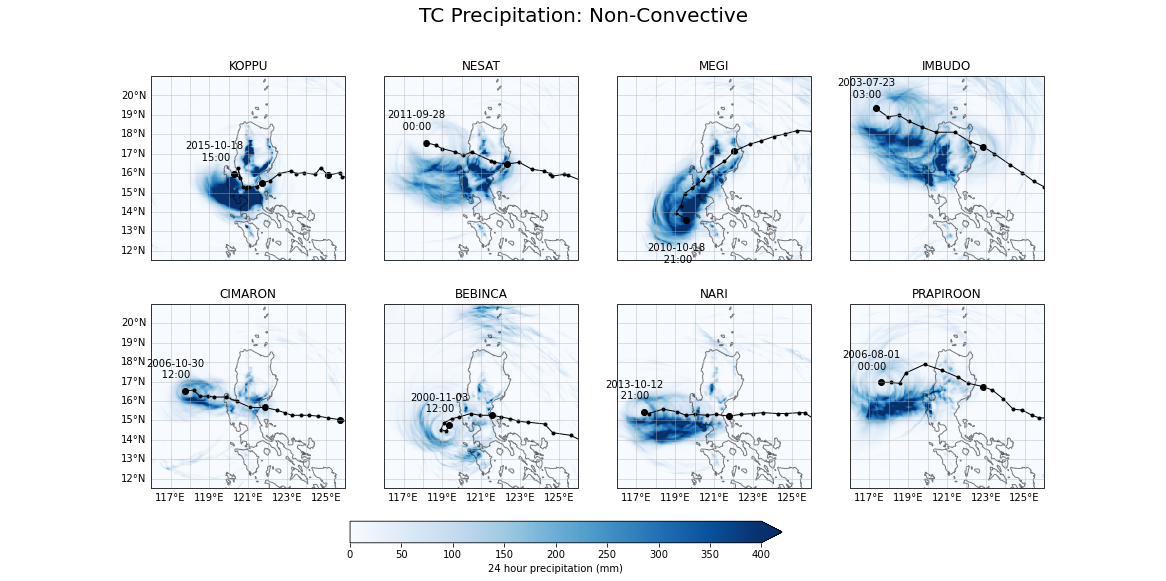

In [84]:
# TC Gallery
v_val = 400

plt.clf()
plt.close('all')

fig, axes = plt.subplots(nrows=2,
                         ncols=4,
                         facecolor='white',
                         figsize=(16,8),
                         subplot_kw={'projection': crs})
i = -1

lim_do = -48
lim_up = 24

for j in range(0,2):
    for k in range(0,4):
        i+=1
        tcname = lf_list.index.values[i]
        tc_ts_o = lf_list.loc[tcname].e_ts
        tc_path = os.path.join(wrf_path_base,tcname.lower()+'_'+'orig')
        tc_list_o = os.listdir(tc_path)
        for wrf_ncs_o in tc_list_o:
            if wrf_ncs_o[0:10]=='wrfout_d02':
                wrf_nc_o = wrf_ncs_o
        tc_nc_path_o = os.path.join(tc_path, wrf_nc_o)

        ncfile_o = Dataset(tc_nc_path_o)
        uv10_o = getvar(ncfile_o, "uvmet10", units="kt", timeidx=tc_ts_o+8)
        ua_1km_o = getvar(ncfile_o, "ua", units="kt", timeidx=tc_ts_o)[7]
        va_1km_o = getvar(ncfile_o, "va", units="kt", timeidx=tc_ts_o)[7]  
        rainnc_24_o = (ncfile_o['RAINNC'][tc_ts_o+8]) - (ncfile_o['RAINNC'][tc_ts_o])

#         # REDUCED
#         tc_ts_r = lf_list.loc[tcname].e_ts
#         tc_path = os.path.join(wrf_path_base,tcname.lower()+'_'+'redu')
#         tc_list_r = os.listdir(tc_path)
#         for wrf_ncs_r in tc_list_r:
#             if wrf_ncs_r[0:10]=='wrfout_d02':
#                 wrf_nc_r = wrf_ncs_r
#         tc_nc_path_r = os.path.join(tc_path, wrf_nc_r)

#         ncfile_r = Dataset(tc_nc_path_r)
#         uv10_r = getvar(ncfile_r, "uvmet10", units="kt", timeidx=tc_ts_r)
#         ua_1km_r = getvar(ncfile_r, "ua", units="kt", timeidx=tc_ts_r)[7]
#         va_1km_r = getvar(ncfile_r, "va", units="kt", timeidx=tc_ts_r)[7]  
#         rainnc_24_r= ncfile_r['RAINNC'][tc_ts_r+8] - ncfile_r['RAINNC'][tc_ts_r]

        lats, lons = latlon_coords(uv10_o)
        time_str = str(uv10_o.Time.values)[0:10] + '\n     ' + str(uv10_o.Time.values)[11:16]
    
        # Get the tracks

        o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']))
#         e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']))
#         r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts']))

#         shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
#         shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']

        orig_lat = np.array(lf_list.loc[tcname]['lat_o'])
        orig_lon = np.array(lf_list.loc[tcname]['lon_o'])
#         enha_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_e']), shift_e)
#         enha_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_e']), shift_e)
#         redu_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_r']), shift_r)
#         redu_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_r']), shift_r)


        o_t_24 = o_t[(o_t<=lim_up) & (o_t>=lim_do)]
        orig_lat_24 = orig_lat[(o_t<=lim_up) & (o_t>=lim_do)]
        orig_lon_24 = orig_lon[(o_t<=lim_up) & (o_t>=lim_do)]
#         redu_lat_24 = redu_lat_shift[(o_t<=lim_up) & (o_t>=lim_do)]
#         redu_lon_24 = redu_lon_shift[(o_t<=lim_up) & (o_t>=lim_do)]
#         enha_lat_24 = enha_lat_shift[(o_t<=lim_up) & (o_t>=lim_do)]
#         enha_lon_24 = enha_lon_shift[(o_t<=lim_up) & (o_t>=lim_do)]

        # plot
        axes[j,k].coastlines(resolution='10m', alpha=.5)
        gl = axes[j,k].gridlines(crs=crs, draw_labels=True, alpha=0.5)
        gl.top_labels = None
        gl.right_labels = None
        
        if k>=1:
            gl.left_labels = None
        if j==0:
            gl.bottom_labels = None
        
        xgrid = np.arange(lon_min-10, lon_max+10, 1)
        ygrid = np.arange(lat_min-10, lat_max+10, 1)
        gl.xlocator = mticker.FixedLocator(xgrid.tolist())
        gl.ylocator = mticker.FixedLocator(ygrid.tolist())
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 10, 'color': 'black'}
        gl.ylabel_style = {'size': 10, 'color': 'black'}
        
        plot_rain = axes[j,k].pcolormesh(lons, lats, (rainnc_24_o), cmap='Blues', vmin=0, vmax=v_val)
#         plot_track_r, = axes[j,k].plot(redu_lon_24, redu_lat_24, 'go-', label='Reduced Track', linewidth=1, markersize=3)
        plot_track_o = axes[j,k].plot(orig_lon_24, orig_lat_24, 'ko-', label='Control Track', linewidth=1, markersize=3)
        axes[j,k].plot(orig_lon_24[::8], orig_lat_24[::8], 'ko', linewidth=1, markersize=6)      
        if tcname=='MEGI':
            axes[j,k].text(orig_lon_24[-1]-2, orig_lat_24[-1]-2.2, time_str, size=10)
        elif tcname=='KOPPU':
            axes[j,k].text(orig_lon_24[-1]-2.5, orig_lat_24[-1]+.65, time_str, size=10)
        elif tcname=='IMBUDO':
            axes[j,k].text(orig_lon_24[-1]-2, orig_lat_24[-1]+.55, time_str, size=10)                 
        else:
            axes[j,k].text(orig_lon_24[-1]-2, orig_lat_24[-1]+.65, time_str, size=10) 
        axes[j,k].set_xlim((116, 126))
        axes[j,k].set_ylim((13.5-2, 19+2))
        axes[j,k].set_title(tcname)
        

fig.suptitle('TC Precipitation: Non-Convective', size=20)
# fig.legend((plot_track_o), ('Control Track'), bbox_to_anchor=(0.565, -0.02))
fig.subplots_adjust(hspace=0.1)
# cbar_ax = fig.add_axes([0, 0.0, 1.0, 0.25], facecolor='none')
cbar_ax = fig.add_axes([0., 0.05, 1.0, 0.25], facecolor='none')
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
cbar = fig.colorbar(plot_rain, orientation='horizontal', ax=cbar_ax, pad=1, extend='max')
cbar.ax.set_xlabel('24 hour precipitation (mm)')
# plt.savefig(os.path.join(path_out, 'ctrl_rainnc.png'), bbox_inches='tight', facecolor='white', dpi=300)
plt.show()

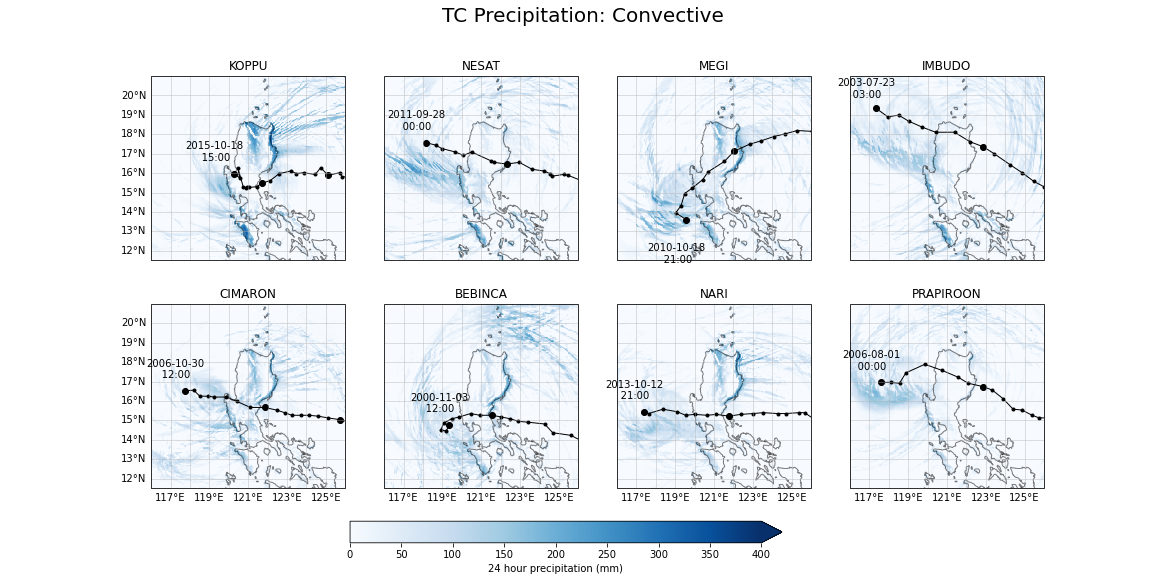

In [85]:
# TC Gallery
v_val = 400

plt.clf()
plt.close('all')

fig, axes = plt.subplots(nrows=2,
                         ncols=4,
                         facecolor='white',
                         figsize=(16,8),
                         subplot_kw={'projection': crs})
i = -1

lim_do = -48
lim_up = 24

for j in range(0,2):
    for k in range(0,4):
        i+=1
        tcname = lf_list.index.values[i]
        tc_ts_o = lf_list.loc[tcname].e_ts
        tc_path = os.path.join(wrf_path_base,tcname.lower()+'_'+'orig')
        tc_list_o = os.listdir(tc_path)
        for wrf_ncs_o in tc_list_o:
            if wrf_ncs_o[0:10]=='wrfout_d02':
                wrf_nc_o = wrf_ncs_o
        tc_nc_path_o = os.path.join(tc_path, wrf_nc_o)

        ncfile_o = Dataset(tc_nc_path_o)
        uv10_o = getvar(ncfile_o, "uvmet10", units="kt", timeidx=tc_ts_o+8)
        ua_1km_o = getvar(ncfile_o, "ua", units="kt", timeidx=tc_ts_o)[7]
        va_1km_o = getvar(ncfile_o, "va", units="kt", timeidx=tc_ts_o)[7]  
        rainnc_24_o = (ncfile_o['RAINC'][tc_ts_o+8]) - (ncfile_o['RAINC'][tc_ts_o])

#         # REDUCED
#         tc_ts_r = lf_list.loc[tcname].e_ts
#         tc_path = os.path.join(wrf_path_base,tcname.lower()+'_'+'redu')
#         tc_list_r = os.listdir(tc_path)
#         for wrf_ncs_r in tc_list_r:
#             if wrf_ncs_r[0:10]=='wrfout_d02':
#                 wrf_nc_r = wrf_ncs_r
#         tc_nc_path_r = os.path.join(tc_path, wrf_nc_r)

#         ncfile_r = Dataset(tc_nc_path_r)
#         uv10_r = getvar(ncfile_r, "uvmet10", units="kt", timeidx=tc_ts_r)
#         ua_1km_r = getvar(ncfile_r, "ua", units="kt", timeidx=tc_ts_r)[7]
#         va_1km_r = getvar(ncfile_r, "va", units="kt", timeidx=tc_ts_r)[7]  
#         rainnc_24_r= ncfile_r['RAINNC'][tc_ts_r+8] - ncfile_r['RAINNC'][tc_ts_r]

        lats, lons = latlon_coords(uv10_o)
        time_str = str(uv10_o.Time.values)[0:10] + '\n     ' + str(uv10_o.Time.values)[11:16]
    
        # Get the tracks

        o_t = (3*(np.array((range(len(lf_list.loc[tcname]['orig_i']))))-lf_list.loc[tcname]['o_ts']))
#         e_t = (3*(np.array((range(len(lf_list.loc[tcname]['enha_i']))))-lf_list.loc[tcname]['e_ts']))
#         r_t = (3*(np.array((range(len(lf_list.loc[tcname]['redu_i']))))-lf_list.loc[tcname]['r_ts']))

#         shift_e = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['e_ts']
#         shift_r = lf_list.loc[tcname]['o_ts']-lf_list.loc[tcname]['r_ts']

        orig_lat = np.array(lf_list.loc[tcname]['lat_o'])
        orig_lon = np.array(lf_list.loc[tcname]['lon_o'])
#         enha_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_e']), shift_e)
#         enha_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_e']), shift_e)
#         redu_lat_shift = np.roll(np.array(lf_list.loc[tcname]['lat_r']), shift_r)
#         redu_lon_shift = np.roll(np.array(lf_list.loc[tcname]['lon_r']), shift_r)


        o_t_24 = o_t[(o_t<=lim_up) & (o_t>=lim_do)]
        orig_lat_24 = orig_lat[(o_t<=lim_up) & (o_t>=lim_do)]
        orig_lon_24 = orig_lon[(o_t<=lim_up) & (o_t>=lim_do)]
#         redu_lat_24 = redu_lat_shift[(o_t<=lim_up) & (o_t>=lim_do)]
#         redu_lon_24 = redu_lon_shift[(o_t<=lim_up) & (o_t>=lim_do)]
#         enha_lat_24 = enha_lat_shift[(o_t<=lim_up) & (o_t>=lim_do)]
#         enha_lon_24 = enha_lon_shift[(o_t<=lim_up) & (o_t>=lim_do)]

        # plot
        axes[j,k].coastlines(resolution='10m', alpha=.5)
        gl = axes[j,k].gridlines(crs=crs, draw_labels=True, alpha=0.5)
        gl.top_labels = None
        gl.right_labels = None
        
        if k>=1:
            gl.left_labels = None
        if j==0:
            gl.bottom_labels = None
        
        xgrid = np.arange(lon_min-10, lon_max+10, 1)
        ygrid = np.arange(lat_min-10, lat_max+10, 1)
        gl.xlocator = mticker.FixedLocator(xgrid.tolist())
        gl.ylocator = mticker.FixedLocator(ygrid.tolist())
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 10, 'color': 'black'}
        gl.ylabel_style = {'size': 10, 'color': 'black'}
        
        plot_rain = axes[j,k].pcolormesh(lons, lats, (rainnc_24_o), cmap='Blues', vmin=0, vmax=v_val)
#         plot_track_r, = axes[j,k].plot(redu_lon_24, redu_lat_24, 'go-', label='Reduced Track', linewidth=1, markersize=3)
        plot_track_o = axes[j,k].plot(orig_lon_24, orig_lat_24, 'ko-', label='Control Track', linewidth=1, markersize=3)
        axes[j,k].plot(orig_lon_24[::8], orig_lat_24[::8], 'ko', linewidth=1, markersize=6)      
        if tcname=='MEGI':
            axes[j,k].text(orig_lon_24[-1]-2, orig_lat_24[-1]-2.2, time_str, size=10)
        elif tcname=='KOPPU':
            axes[j,k].text(orig_lon_24[-1]-2.5, orig_lat_24[-1]+.65, time_str, size=10)
        elif tcname=='IMBUDO':
            axes[j,k].text(orig_lon_24[-1]-2, orig_lat_24[-1]+.55, time_str, size=10)                 
        else:
            axes[j,k].text(orig_lon_24[-1]-2, orig_lat_24[-1]+.65, time_str, size=10) 
        axes[j,k].set_xlim((116, 126))
        axes[j,k].set_ylim((13.5-2, 19+2))
        axes[j,k].set_title(tcname)
        

fig.suptitle('TC Precipitation: Convective', size=20)
# fig.legend((plot_track_o), ('Control Track'), bbox_to_anchor=(0.565, -0.02))
fig.subplots_adjust(hspace=0.1)
# cbar_ax = fig.add_axes([0, 0.0, 1.0, 0.25], facecolor='none')
cbar_ax = fig.add_axes([0., 0.05, 1.0, 0.25], facecolor='none')
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
cbar = fig.colorbar(plot_rain, orientation='horizontal', ax=cbar_ax, pad=1, extend='max')
cbar.ax.set_xlabel('24 hour precipitation (mm)')
# plt.savefig(os.path.join(path_out, 'ctrl_rainc.png'), bbox_inches='tight', facecolor='white', dpi=300)
plt.show()

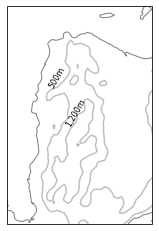

In [136]:
import matplotlib
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

fig = plt.figure(figsize=(6,4))    
ax = fig.add_subplot(111, facecolor='None', projection=crs)
ax.coastlines(resolution='10m', alpha=0.5)
hgt_m = getvar(ncfile_o, "ter", timeidx=tc_ts_o)
lats, lons = latlon_coords(uv10_o)
labels = [500,1200]
plot_ter = plt.contour(lons, lats, hgt_m, labels, alpha=0.25, colors='black')
# plt.clabel(plot_ter, inline=1, fontsize=10)
# labels = [500,1500,2500,3500]
# for i in range(len(labels)):
#     plot_ter.collections[i].set_label(labels[i])
# plt.contour(lons, lats, hgt_m, [250,1000,2000,3000], alpha=0.5, colors='black')
# axes[j,k].set_xlim((120, 122))     
# axes[j,k].set_ylim((16, 19))  
plt.text(120.55,17.89, '500m', rotation=60,size=8)
plt.text(120.78,17.35, '1,200m', rotation=60,size=8)
plt.xlim((120,122))
plt.ylim((16,19))
        
plt.show()


In [19]:
lats.shape

(498, 498)